In [2]:
#pip install talos

  Using cached talos-1.3-py3-none-any.whl (56 kB)
  Using cached wrangle-0.7.2-py3-none-any.whl (52 kB)
  Using cached sklearn-0.0.post7.tar.gz (3.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached astetik-1.13-py3-none-any.whl (5.4 MB)
  Using cached kerasplotlib-1.0-py3-none-any.whl (4.3 kB)
  Using cached chances-0.1.9.tar.gz (35 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 26.6/26.6 MB 8.6 MB/s eta 0:00:00
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41604 sha256=8e8ef095dbb6918966a0d34c104e8c416b8278d84ff9a3e23efbcc6be1b2f22b
  Stored in directory: c:\users\nathdwar\appdata\local\pip\cache\wheels\1f\da\8d\55a7d2ac91aecfe7785fa3c1931a822d51c2e2d289d721963e
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2971 sha256=f45a6784450147252027505017f3fbde8

In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import talos
from talos.utils import lr_normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import metrics
import keras.backend as K
from functools import partial

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  0



In [3]:
df = pd.read_csv('datasets/final_db.csv', index_col=0)
df.sort_index(inplace=True)
df.head(3)

,target,STOCH_slowk,STOCH_slowd,MACD,MACD_hist,CCI_5,CCI_10,CCI_21,CCI_50,MOM_5,MOM_10,MOM_21,RSI_5,RSI_10,RSI_21,RSI_50
Day,,,,,,,,,,,,,,,,
2014-09-17,0.0,64.131513,55.829197,-6.216836,8.287389,-63.110875,-52.333847,-132.685371,-89.932417,-55.182007,-57.814026,-104.394013,19.363753,31.929726,32.267866,39.540104
2014-09-18,0.0,64.131513,55.829197,-6.216836,8.287389,-63.110875,-52.333847,-132.685371,-89.932417,-55.182007,-57.814026,-104.394013,19.363753,31.929726,32.267866,39.540104
2014-09-19,0.0,64.131513,55.829197,-6.216836,8.287389,-63.110875,-52.333847,-132.685371,-89.932417,-55.182007,-57.814026,-104.394013,19.363753,31.929726,32.267866,39.540104


---
### Model and Functions

In [4]:
# Function to get class weights:
def cwts(data):
    c0, c1 = np.bincount(data['target'])
    #making the weights inversely proportional to the amount of observations:
    w0, w1 = (1/c0)*(len(data))/2, (1/c1)*(len(data))/2
    return {0: w0, 1:w1}

# Defining Recall, Precision, Specificity and F1 metrics:
#(https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05)
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras


def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

#========================================================================================#
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    #rampup epochs
    if epoch<=10:
        return lr
    return lr * tf.math.exp(-0.1*epoch)

#========================================================================================#
#LSTM ARCHITECTURE
def lstm_model(x_train, y_train, x_val, y_val, params):

    tf.keras.backend.clear_session()
    #This function defines the LSTM model
    win_length = params['window']
    batch_size = params['batch_size']
    num_features= x_train.shape[1]
    train_generator = TimeseriesGenerator(scaledtrain, y_train, length= win_length, sampling_rate = 1, batch_size= batch_size)
    test_generator = TimeseriesGenerator(scaledtest, y_val, length= win_length, sampling_rate = 1, batch_size= batch_size)
    #==================================================================#
    # MODEL ARCHITECTURE
    model = Sequential()
    #Input and first LSTM layer:
    model.add(LSTM(units=params['u1'], input_shape = (win_length, num_features), \
    return_sequences=True))
    # Dropout layer
    model.add(Dropout(params['dropout']))
    #Add second layer LSTM
    model.add(LSTM(units=params['u2'], return_sequences=False))
    #Dropout layer
    model.add(Dropout(params['dropout']))
    #Add a Dense layer
    model.add(Dense(params['dense_neurons'], activation = params['activation']))
    
    #Add the output layer – output layer
    model.add(Dense(1, activation = 'sigmoid'))#output layer

    #==================================================================#
    # Defining Early Stopping to avoid overfitting (after 3 attempts)
    early_stopping = EarlyStopping(monitor='val_loss',patience = 10, mode='min', restore_best_weights=True)

    # Using exponential decay:
    
    callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

    # Compiling
    # (lr=lr_normalizer(params['lr'], params['optimizer']))
    # callbacks = [early_stopping, callbacklr],
    model.compile(loss='binary_crossentropy', 
                    optimizer = params['optimizer'], 
                    metrics=['accuracy',precision,recall,f1,specificity,])
    
    history = model.fit(train_generator,
                        validation_data=test_generator, # validation sample with features
                        epochs = params['epochs'], # validation sample with labels
                        shuffle=False, callbacks = [early_stopping, callbacklr],#callbacklr
                        class_weight = class_weight, # imbalanced data
                        verbose=1
                        )

    return(history, model)

In [5]:
# We scale the data so hasten the LSTM's conversion
scaler = MinMaxScaler() 


# Features x Target

features = df.iloc[:,1:]
target = df.iloc[:,0]

# Shuffle is set to False because it is a timeseries, and the order matters.
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0, shuffle = False)

# Scaling
scaledtrain = scaler.fit_transform(x_train)
scaledtest = scaler.transform(x_test)

In [6]:
# Getting class weights to adjust accordingly during training
class_weight = cwts(df)
class_weight

{0: 1.0964812712826333, 1: 0.9191246431969553}

---
### Talos Hyperparameter Tuning

In [7]:

# Defining parameters considered in the hyperparameter tuning
params = {'lr': [1e-2,1e-3, 1e-4],
        'u1': [128,256], 
        'u2': [128,256], 
        'dropout': [0.3, 0.5],
        'batch_size': [32,64, 256], 
        'epochs': [100],
        'optimizer': ['Adam'],
        'activation': ['relu','elu'],
        'dense_neurons': [32, 64],
        'window': [21,50,200],
        }

# Scanning for best hyperparameters with Talos
scan = talos.Scan(x = x_train, y = y_train, x_val = x_test, y_val = y_test, params = params, model = lstm_model,experiment_name = 'lstm_model_val2', fraction_limit = 0.2)

  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/100
43/43 [==============================] - 28s 421ms/step - loss: 0.6938 - accuracy: 0.5487 - precision: 0.4741 - recall: 0.6625 - f1: 0.5133 - specificity: 0.3158 - val_loss: 0.6875 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 16s 373ms/step - loss: 0.6909 - accuracy: 0.5502 - precision: 0.4416 - recall: 0.6356 - f1: 0.5013 - specificity: 0.3550 - val_loss: 0.6877 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 18s 426ms/step - loss: 0.6904 - accuracy: 0.5361 - precision: 0.5023 - recall: 0.6922 - f1: 0.5474 - specificity: 0.2945 - val_loss: 0.6915 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

  1%|          | 1/172 [03:26<9:49:40, 206.90s/it]

Epoch 1/100
22/22 [==============================] - 34s 1s/step - loss: 0.6929 - accuracy: 0.5383 - precision: 0.4431 - recall: 0.6558 - f1: 0.4977 - specificity: 0.2974 - val_loss: 0.6896 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 32s 1s/step - loss: 0.6914 - accuracy: 0.5465 - precision: 0.4882 - recall: 0.6402 - f1: 0.5097 - specificity: 0.3246 - val_loss: 0.6911 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 34s 2s/step - loss: 0.6918 - accuracy: 0.5219 - precision: 0.5073 - recall: 0.6507 - f1: 0.5115 - specificity: 0.2867 - val_loss: 0.6923 - val_accuracy: 0.5455 - val_precision: 0.1250 - val_recall: 0.0323 - val_f1: 0.0513 - val_specificity: 0.9495 - lr: 0.0010
Epoch 4/100
22/22 [===============

  1%|          | 2/172 [09:21<13:51:55, 293.62s/it]

Epoch 1/100
24/24 [==============================] - 19s 472ms/step - loss: 0.6946 - accuracy: 0.5512 - precision: 0.4751 - recall: 0.6957 - f1: 0.5328 - specificity: 0.3105 - val_loss: 0.7104 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 9s 368ms/step - loss: 0.6930 - accuracy: 0.5465 - precision: 0.3840 - recall: 0.6054 - f1: 0.4600 - specificity: 0.3935 - val_loss: 0.7034 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 9s 364ms/step - loss: 0.6912 - accuracy: 0.5244 - precision: 0.3526 - recall: 0.4877 - f1: 0.3698 - specificity: 0.5074 - val_loss: 0.7086 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

  2%|▏         | 3/172 [13:17<12:33:38, 267.56s/it]

Epoch 1/100
6/6 [==============================] - 9s 587ms/step - loss: 0.7006 - accuracy: 0.4941 - precision: 0.5052 - recall: 0.5641 - f1: 0.4425 - specificity: 0.4290 - val_loss: 0.6917 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 372ms/step - loss: 0.6990 - accuracy: 0.4895 - precision: 0.6021 - recall: 0.4769 - f1: 0.4514 - specificity: 0.5603 - val_loss: 0.6919 - val_accuracy: 0.5191 - val_precision: 0.4787 - val_recall: 0.9000 - val_f1: 0.6241 - val_specificity: 0.0615 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 361ms/step - loss: 0.6912 - accuracy: 0.5505 - precision: 0.5608 - recall: 0.8666 - f1: 0.6795 - specificity: 0.1606 - val_loss: 0.6912 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

  2%|▏         | 4/172 [14:16<8:38:16, 185.10s/it] 

Epoch 1/100
48/48 [==============================] - 9s 106ms/step - loss: 0.6954 - accuracy: 0.5335 - precision: 0.5399 - recall: 0.5852 - f1: 0.5047 - specificity: 0.4297 - val_loss: 0.7112 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 4s 91ms/step - loss: 0.6924 - accuracy: 0.5486 - precision: 0.5103 - recall: 0.5988 - f1: 0.4946 - specificity: 0.4254 - val_loss: 0.7148 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 5s 107ms/step - loss: 0.6918 - accuracy: 0.5381 - precision: 0.4573 - recall: 0.6238 - f1: 0.4910 - specificity: 0.3632 - val_loss: 0.7016 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/48

  3%|▎         | 5/172 [16:35<7:49:14, 168.59s/it]

Epoch 1/100
24/24 [==============================] - 14s 278ms/step - loss: 0.6969 - accuracy: 0.5400 - precision: 0.5646 - recall: 0.6877 - f1: 0.5585 - specificity: 0.3275 - val_loss: 0.7129 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 4s 156ms/step - loss: 0.6949 - accuracy: 0.5374 - precision: 0.4187 - recall: 0.5445 - f1: 0.4251 - specificity: 0.4727 - val_loss: 0.7146 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 4s 149ms/step - loss: 0.6943 - accuracy: 0.5341 - precision: 0.4004 - recall: 0.6314 - f1: 0.4757 - specificity: 0.3672 - val_loss: 0.6944 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

  3%|▎         | 6/172 [17:58<6:25:45, 139.43s/it]

Epoch 1/100
47/47 [==============================] - 11s 136ms/step - loss: 0.6926 - accuracy: 0.5324 - precision: 0.4933 - recall: 0.6011 - f1: 0.5076 - specificity: 0.4045 - val_loss: 0.7108 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 5s 116ms/step - loss: 0.6947 - accuracy: 0.5284 - precision: 0.5020 - recall: 0.5330 - f1: 0.4440 - specificity: 0.4582 - val_loss: 0.7084 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 6s 124ms/step - loss: 0.6917 - accuracy: 0.5418 - precision: 0.4562 - recall: 0.5602 - f1: 0.4562 - specificity: 0.4536 - val_loss: 0.6989 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
47/

  4%|▍         | 7/172 [20:02<6:09:31, 134.37s/it]

Epoch 1/100
6/6 [==============================] - 8s 582ms/step - loss: 0.6976 - accuracy: 0.5354 - precision: 0.4454 - recall: 0.6599 - f1: 0.4959 - specificity: 0.3259 - val_loss: 0.6996 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 371ms/step - loss: 0.7082 - accuracy: 0.4672 - precision: 0.2739 - recall: 0.2254 - f1: 0.2029 - specificity: 0.7947 - val_loss: 0.6925 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 414ms/step - loss: 0.6939 - accuracy: 0.5518 - precision: 0.5523 - recall: 0.9921 - f1: 0.7087 - specificity: 0.0060 - val_loss: 0.6906 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=====================

  5%|▍         | 8/172 [20:59<4:59:58, 109.75s/it]

Epoch 1/100
24/24 [==============================] - 14s 416ms/step - loss: 0.6963 - accuracy: 0.5311 - precision: 0.4834 - recall: 0.6396 - f1: 0.5159 - specificity: 0.3346 - val_loss: 0.7133 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 10s 409ms/step - loss: 0.6926 - accuracy: 0.5304 - precision: 0.4231 - recall: 0.5047 - f1: 0.3997 - specificity: 0.4922 - val_loss: 0.7131 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 8s 340ms/step - loss: 0.6924 - accuracy: 0.5405 - precision: 0.4164 - recall: 0.6353 - f1: 0.4871 - specificity: 0.3471 - val_loss: 0.6980 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24

  5%|▌         | 9/172 [24:04<6:02:08, 133.30s/it]

Epoch 1/100
43/43 [==============================] - 50s 1s/step - loss: 0.6963 - accuracy: 0.5353 - precision: 0.5675 - recall: 0.5696 - f1: 0.5065 - specificity: 0.4412 - val_loss: 0.6876 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 43s 1s/step - loss: 0.6914 - accuracy: 0.5524 - precision: 0.5845 - recall: 0.6878 - f1: 0.5951 - specificity: 0.3355 - val_loss: 0.6873 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 45s 1s/step - loss: 0.6919 - accuracy: 0.5494 - precision: 0.5783 - recall: 0.6286 - f1: 0.5330 - specificity: 0.3702 - val_loss: 0.6866 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [===

  6%|▌         | 10/172 [37:43<15:31:11, 344.89s/it]

Epoch 1/100
6/6 [==============================] - 8s 552ms/step - loss: 0.6982 - accuracy: 0.4908 - precision: 0.3708 - recall: 0.4426 - f1: 0.3687 - specificity: 0.5538 - val_loss: 0.6933 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 223ms/step - loss: 0.6947 - accuracy: 0.5479 - precision: 0.5735 - recall: 0.8272 - f1: 0.6650 - specificity: 0.2270 - val_loss: 0.6922 - val_accuracy: 0.5246 - val_precision: 0.4841 - val_recall: 0.9111 - val_f1: 0.6313 - val_specificity: 0.0692 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 228ms/step - loss: 0.6920 - accuracy: 0.5184 - precision: 0.5585 - recall: 0.6500 - f1: 0.5961 - specificity: 0.3666 - val_loss: 0.6920 - val_accuracy: 0.5273 - val_precision: 0.4754 - val_recall: 0.7401 - val_f1: 0.5786 - val_specificity: 0.2255 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1s 

  6%|▋         | 11/172 [38:21<11:13:11, 250.88s/it]

Epoch 1/100
43/43 [==============================] - 104s 2s/step - loss: 0.6974 - accuracy: 0.5286 - precision: 0.4193 - recall: 0.6444 - f1: 0.4925 - specificity: 0.3079 - val_loss: 0.6876 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 96s 2s/step - loss: 0.6907 - accuracy: 0.5368 - precision: 0.4610 - recall: 0.6390 - f1: 0.5033 - specificity: 0.3180 - val_loss: 0.6876 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 96s 2s/step - loss: 0.6904 - accuracy: 0.5316 - precision: 0.4619 - recall: 0.6121 - f1: 0.4760 - specificity: 0.3353 - val_loss: 0.6875 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [==

  7%|▋         | 12/172 [1:02:25<27:17:25, 614.03s/it]

Epoch 1/100
6/6 [==============================] - 16s 1s/step - loss: 0.7050 - accuracy: 0.5264 - precision: 0.4718 - recall: 0.5751 - f1: 0.4643 - specificity: 0.4364 - val_loss: 0.6929 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 5s 800ms/step - loss: 0.6996 - accuracy: 0.4676 - precision: 0.6633 - recall: 0.3353 - f1: 0.2681 - specificity: 0.6783 - val_loss: 0.6952 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 5s 880ms/step - loss: 0.6931 - accuracy: 0.4763 - precision: 0.4936 - recall: 0.4655 - f1: 0.4208 - specificity: 0.4799 - val_loss: 0.6901 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=======================

  8%|▊         | 13/172 [1:04:19<20:25:24, 462.42s/it]

Epoch 1/100
47/47 [==============================] - 32s 540ms/step - loss: 0.6970 - accuracy: 0.5385 - precision: 0.4346 - recall: 0.6113 - f1: 0.4749 - specificity: 0.4006 - val_loss: 0.7170 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 23s 494ms/step - loss: 0.6908 - accuracy: 0.5271 - precision: 0.3857 - recall: 0.5730 - f1: 0.4432 - specificity: 0.3883 - val_loss: 0.7038 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 23s 493ms/step - loss: 0.6922 - accuracy: 0.5438 - precision: 0.3935 - recall: 0.6320 - f1: 0.4763 - specificity: 0.3578 - val_loss: 0.6999 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

  8%|▊         | 14/172 [1:16:34<23:54:54, 544.90s/it]

Epoch 1/100
48/48 [==============================] - 18s 204ms/step - loss: 0.6931 - accuracy: 0.5387 - precision: 0.4989 - recall: 0.6220 - f1: 0.5025 - specificity: 0.3821 - val_loss: 0.7035 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 9s 179ms/step - loss: 0.6919 - accuracy: 0.5413 - precision: 0.4584 - recall: 0.6503 - f1: 0.5070 - specificity: 0.3421 - val_loss: 0.6941 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 8s 172ms/step - loss: 0.6929 - accuracy: 0.5184 - precision: 0.3801 - recall: 0.5078 - f1: 0.3923 - specificity: 0.4841 - val_loss: 0.6959 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/

  9%|▊         | 15/172 [1:19:22<18:48:09, 431.15s/it]

Epoch 1/100
47/47 [==============================] - 21s 222ms/step - loss: 0.6935 - accuracy: 0.5378 - precision: 0.5216 - recall: 0.6532 - f1: 0.5253 - specificity: 0.3397 - val_loss: 0.7003 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 9s 191ms/step - loss: 0.6906 - accuracy: 0.5284 - precision: 0.3646 - recall: 0.4927 - f1: 0.3849 - specificity: 0.5042 - val_loss: 0.7056 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 9s 192ms/step - loss: 0.6914 - accuracy: 0.5365 - precision: 0.4471 - recall: 0.5813 - f1: 0.4535 - specificity: 0.4154 - val_loss: 0.6976 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
47/

  9%|▉         | 16/172 [1:23:41<16:26:46, 379.53s/it]

Epoch 1/100
24/24 [==============================] - 19s 458ms/step - loss: 0.6921 - accuracy: 0.5338 - precision: 0.5417 - recall: 0.6072 - f1: 0.5139 - specificity: 0.3861 - val_loss: 0.7249 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 11s 444ms/step - loss: 0.6973 - accuracy: 0.5304 - precision: 0.4707 - recall: 0.6013 - f1: 0.4671 - specificity: 0.3880 - val_loss: 0.6952 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 7s 289ms/step - loss: 0.6996 - accuracy: 0.4977 - precision: 0.3822 - recall: 0.4537 - f1: 0.3515 - specificity: 0.5590 - val_loss: 0.6907 - val_accuracy: 0.5252 - val_precision: 0.5113 - val_recall: 1.0000 - val_f1: 0.6703 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [===

 10%|▉         | 17/172 [1:26:54<13:54:56, 323.21s/it]

Epoch 1/100
43/43 [==============================] - 67s 1s/step - loss: 0.6973 - accuracy: 0.5309 - precision: 0.4472 - recall: 0.6464 - f1: 0.5104 - specificity: 0.3268 - val_loss: 0.6873 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 67s 2s/step - loss: 0.6913 - accuracy: 0.5428 - precision: 0.4938 - recall: 0.6660 - f1: 0.5164 - specificity: 0.2982 - val_loss: 0.6884 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 73s 2s/step - loss: 0.6900 - accuracy: 0.5428 - precision: 0.4983 - recall: 0.6454 - f1: 0.5120 - specificity: 0.3625 - val_loss: 0.6907 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [===

 10%|█         | 18/172 [1:40:44<20:20:50, 475.65s/it]

Epoch 1/100
6/6 [==============================] - 10s 915ms/step - loss: 0.6980 - accuracy: 0.4997 - precision: 0.3909 - recall: 0.4769 - f1: 0.3562 - specificity: 0.5108 - val_loss: 0.6903 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 4s 701ms/step - loss: 0.6972 - accuracy: 0.4508 - precision: 0.5582 - recall: 0.3276 - f1: 0.3015 - specificity: 0.6560 - val_loss: 0.6929 - val_accuracy: 0.5312 - val_precision: 0.3019 - val_recall: 0.2286 - val_f1: 0.2602 - val_specificity: 0.7849 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 5s 890ms/step - loss: 0.6920 - accuracy: 0.5197 - precision: 0.5480 - recall: 0.7095 - f1: 0.6111 - specificity: 0.2770 - val_loss: 0.6905 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] 

 11%|█         | 19/172 [1:42:18<15:20:27, 360.97s/it]

Epoch 1/100
47/47 [==============================] - 14s 195ms/step - loss: 0.6908 - accuracy: 0.5465 - precision: 0.4592 - recall: 0.6029 - f1: 0.4740 - specificity: 0.4087 - val_loss: 0.7108 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 8s 176ms/step - loss: 0.6935 - accuracy: 0.5291 - precision: 0.4174 - recall: 0.5772 - f1: 0.4587 - specificity: 0.4019 - val_loss: 0.7010 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 10s 213ms/step - loss: 0.6909 - accuracy: 0.5338 - precision: 0.3588 - recall: 0.5006 - f1: 0.3902 - specificity: 0.4916 - val_loss: 0.7069 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
47

 12%|█▏        | 20/172 [1:46:50<14:06:56, 334.32s/it]

Epoch 1/100
47/47 [==============================] - 26s 428ms/step - loss: 0.7057 - accuracy: 0.5097 - precision: 0.4847 - recall: 0.5664 - f1: 0.4879 - specificity: 0.4081 - val_loss: 0.7050 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 19s 412ms/step - loss: 0.6904 - accuracy: 0.5291 - precision: 0.4693 - recall: 0.4920 - f1: 0.4182 - specificity: 0.5051 - val_loss: 0.7058 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 18s 372ms/step - loss: 0.6933 - accuracy: 0.5358 - precision: 0.5378 - recall: 0.5949 - f1: 0.5141 - specificity: 0.3967 - val_loss: 0.7023 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 12%|█▏        | 21/172 [1:54:54<15:54:32, 379.29s/it]

Epoch 1/100
47/47 [==============================] - 32s 592ms/step - loss: 0.6972 - accuracy: 0.5104 - precision: 0.5031 - recall: 0.5346 - f1: 0.4676 - specificity: 0.4501 - val_loss: 0.7039 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 27s 579ms/step - loss: 0.6948 - accuracy: 0.5251 - precision: 0.4311 - recall: 0.5291 - f1: 0.4234 - specificity: 0.4522 - val_loss: 0.7048 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 26s 545ms/step - loss: 0.6930 - accuracy: 0.5144 - precision: 0.4370 - recall: 0.5175 - f1: 0.4414 - specificity: 0.4458 - val_loss: 0.6994 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 13%|█▎        | 22/172 [2:06:11<19:31:19, 468.53s/it]

Epoch 1/100
43/43 [==============================] - 114s 3s/step - loss: 0.6981 - accuracy: 0.5048 - precision: 0.4874 - recall: 0.5993 - f1: 0.4965 - specificity: 0.3503 - val_loss: 0.6873 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 111s 3s/step - loss: 0.6934 - accuracy: 0.5331 - precision: 0.5158 - recall: 0.5686 - f1: 0.4771 - specificity: 0.4234 - val_loss: 0.6879 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 112s 3s/step - loss: 0.6946 - accuracy: 0.5346 - precision: 0.5452 - recall: 0.7495 - f1: 0.6091 - specificity: 0.2264 - val_loss: 0.6903 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [

 13%|█▎        | 23/172 [2:45:45<43:03:21, 1040.28s/it]

Epoch 1/100
47/47 [==============================] - 32s 589ms/step - loss: 0.7005 - accuracy: 0.5197 - precision: 0.5068 - recall: 0.5806 - f1: 0.4815 - specificity: 0.4162 - val_loss: 0.7169 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 26s 558ms/step - loss: 0.6932 - accuracy: 0.5331 - precision: 0.4426 - recall: 0.5775 - f1: 0.4781 - specificity: 0.4251 - val_loss: 0.7113 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 26s 559ms/step - loss: 0.6934 - accuracy: 0.5385 - precision: 0.4496 - recall: 0.5739 - f1: 0.4532 - specificity: 0.4163 - val_loss: 0.7054 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 14%|█▍        | 24/172 [2:58:05<39:03:40, 950.14s/it] 

Epoch 1/100
6/6 [==============================] - 13s 1s/step - loss: 0.6990 - accuracy: 0.5304 - precision: 0.5666 - recall: 0.7469 - f1: 0.5820 - specificity: 0.2553 - val_loss: 0.6918 - val_accuracy: 0.5163 - val_precision: 0.4950 - val_recall: 0.9317 - val_f1: 0.6460 - val_specificity: 0.0427 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 6s 1s/step - loss: 0.6960 - accuracy: 0.4508 - precision: 0.3533 - recall: 0.1439 - f1: 0.1290 - specificity: 0.8638 - val_loss: 0.6937 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 6s 1s/step - loss: 0.6938 - accuracy: 0.4729 - precision: 0.5864 - recall: 0.3559 - f1: 0.2936 - specificity: 0.6459 - val_loss: 0.6912 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 15%|█▍        | 25/172 [3:00:21<28:49:15, 705.82s/it]

Epoch 1/100
6/6 [==============================] - 9s 811ms/step - loss: 0.7003 - accuracy: 0.5085 - precision: 0.4393 - recall: 0.5921 - f1: 0.4561 - specificity: 0.3912 - val_loss: 0.6916 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 3s 586ms/step - loss: 0.6961 - accuracy: 0.4895 - precision: 0.5680 - recall: 0.6064 - f1: 0.5149 - specificity: 0.4084 - val_loss: 0.6913 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 4s 615ms/step - loss: 0.6936 - accuracy: 0.5092 - precision: 0.5468 - recall: 0.7663 - f1: 0.6288 - specificity: 0.2141 - val_loss: 0.6909 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 15%|█▌        | 26/172 [3:01:44<21:03:21, 519.19s/it]

Epoch 1/100
6/6 [==============================] - 12s 1s/step - loss: 0.7279 - accuracy: 0.5090 - precision: 0.4601 - recall: 0.5677 - f1: 0.4492 - specificity: 0.4225 - val_loss: 0.6952 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 6s 1s/step - loss: 0.7017 - accuracy: 0.4682 - precision: 0.5303 - recall: 0.3826 - f1: 0.3391 - specificity: 0.6187 - val_loss: 0.6941 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 6s 1s/step - loss: 0.6915 - accuracy: 0.5084 - precision: 0.5479 - recall: 0.5587 - f1: 0.5156 - specificity: 0.4336 - val_loss: 0.6899 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 16%|█▌        | 27/172 [3:04:21<16:31:57, 410.46s/it]

Epoch 1/100
6/6 [==============================] - 30s 4s/step - loss: 0.6982 - accuracy: 0.5130 - precision: 0.5389 - recall: 0.6766 - f1: 0.5383 - specificity: 0.3229 - val_loss: 0.6931 - val_accuracy: 0.5348 - val_precision: 0.4667 - val_recall: 0.3373 - val_f1: 0.3916 - val_specificity: 0.6923 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 27s 5s/step - loss: 0.6944 - accuracy: 0.4773 - precision: 0.5484 - recall: 0.5517 - f1: 0.4808 - specificity: 0.4445 - val_loss: 0.6988 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 27s 4s/step - loss: 0.6915 - accuracy: 0.5197 - precision: 0.5448 - recall: 0.7592 - f1: 0.6279 - specificity: 0.2341 - val_loss: 0.6967 - val_accuracy: 0.4385 - val_precision: 0.4396 - val_recall: 0.9639 - val_f1: 0.6038 - val_specificity: 0.0192 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 27s 5s/st

 16%|█▋        | 28/172 [3:15:21<19:24:57, 485.40s/it]

Epoch 1/100
24/24 [==============================] - 18s 558ms/step - loss: 0.6947 - accuracy: 0.5358 - precision: 0.4943 - recall: 0.6583 - f1: 0.5306 - specificity: 0.3293 - val_loss: 0.7270 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 12s 513ms/step - loss: 0.6917 - accuracy: 0.5431 - precision: 0.4200 - recall: 0.5733 - f1: 0.4444 - specificity: 0.4292 - val_loss: 0.7120 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 12s 521ms/step - loss: 0.6938 - accuracy: 0.5271 - precision: 0.3764 - recall: 0.5798 - f1: 0.4418 - specificity: 0.4135 - val_loss: 0.6976 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 17%|█▋        | 29/172 [3:19:44<16:37:55, 418.71s/it]

Epoch 1/100
24/24 [==============================] - 11s 279ms/step - loss: 0.6924 - accuracy: 0.5394 - precision: 0.4422 - recall: 0.6399 - f1: 0.4972 - specificity: 0.3605 - val_loss: 0.7098 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 9s 373ms/step - loss: 0.6936 - accuracy: 0.5328 - precision: 0.4623 - recall: 0.6014 - f1: 0.4745 - specificity: 0.3837 - val_loss: 0.6987 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 221ms/step - loss: 0.6930 - accuracy: 0.5223 - precision: 0.3339 - recall: 0.5104 - f1: 0.3914 - specificity: 0.4849 - val_loss: 0.7008 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 17%|█▋        | 30/172 [3:21:24<12:44:14, 322.92s/it]

Epoch 1/100
47/47 [==============================] - 36s 681ms/step - loss: 0.6962 - accuracy: 0.5458 - precision: 0.4765 - recall: 0.6653 - f1: 0.5156 - specificity: 0.3333 - val_loss: 0.7137 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 28s 593ms/step - loss: 0.6926 - accuracy: 0.5411 - precision: 0.4306 - recall: 0.6141 - f1: 0.4725 - specificity: 0.3814 - val_loss: 0.7043 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 29s 618ms/step - loss: 0.6914 - accuracy: 0.5472 - precision: 0.4204 - recall: 0.6232 - f1: 0.4814 - specificity: 0.3775 - val_loss: 0.7014 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 18%|█▊        | 31/172 [3:35:05<18:29:53, 472.30s/it]

Epoch 1/100
22/22 [==============================] - 55s 2s/step - loss: 0.6936 - accuracy: 0.5375 - precision: 0.5422 - recall: 0.6945 - f1: 0.5600 - specificity: 0.3106 - val_loss: 0.6908 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 48s 2s/step - loss: 0.6983 - accuracy: 0.5234 - precision: 0.5762 - recall: 0.6763 - f1: 0.5795 - specificity: 0.3159 - val_loss: 0.6909 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 45s 2s/step - loss: 0.6931 - accuracy: 0.5353 - precision: 0.5837 - recall: 0.6668 - f1: 0.5944 - specificity: 0.3566 - val_loss: 0.6909 - val_accuracy: 0.5668 - val_precision: 0.4611 - val_recall: 0.2172 - val_f1: 0.2882 - val_specificity: 0.8557 - lr: 0.0010
Epoch 4/100
22/22 [===============

 19%|█▊        | 32/172 [3:43:41<18:53:06, 485.62s/it]

Epoch 1/100
24/24 [==============================] - 20s 628ms/step - loss: 0.6939 - accuracy: 0.5344 - precision: 0.4648 - recall: 0.5855 - f1: 0.4726 - specificity: 0.4233 - val_loss: 0.7358 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 16s 659ms/step - loss: 0.6895 - accuracy: 0.5498 - precision: 0.4677 - recall: 0.6098 - f1: 0.4742 - specificity: 0.3906 - val_loss: 0.7278 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 14s 591ms/step - loss: 0.6922 - accuracy: 0.5398 - precision: 0.4097 - recall: 0.6002 - f1: 0.4610 - specificity: 0.3938 - val_loss: 0.7056 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 19%|█▉        | 33/172 [3:49:01<16:49:43, 435.85s/it]

Epoch 1/100
6/6 [==============================] - 35s 5s/step - loss: 0.7133 - accuracy: 0.4818 - precision: 0.3462 - recall: 0.6655 - f1: 0.4548 - specificity: 0.3333 - val_loss: 0.7091 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 29s 5s/step - loss: 0.6927 - accuracy: 0.5182 - precision: 0.4667 - recall: 0.5602 - f1: 0.4795 - specificity: 0.4142 - val_loss: 0.6907 - val_accuracy: 0.5615 - val_precision: 1.0000 - val_recall: 0.0120 - val_f1: 0.0238 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 28s 5s/step - loss: 0.6918 - accuracy: 0.4803 - precision: 0.5811 - recall: 0.2638 - f1: 0.3443 - specificity: 0.7628 - val_loss: 0.6950 - val_accuracy: 0.4920 - val_precision: 0.4464 - val_recall: 0.6024 - val_f1: 0.5128 - val_specificity: 0.4038 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 28s 5s/st

 20%|█▉        | 34/172 [3:57:16<17:23:29, 453.69s/it]

Epoch 1/100
6/6 [==============================] - 10s 901ms/step - loss: 0.6979 - accuracy: 0.5420 - precision: 0.4679 - recall: 0.6673 - f1: 0.5240 - specificity: 0.3355 - val_loss: 0.6984 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 4s 673ms/step - loss: 0.7088 - accuracy: 0.4580 - precision: 0.5970 - recall: 0.1995 - f1: 0.2038 - specificity: 0.8069 - val_loss: 0.6916 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 4s 725ms/step - loss: 0.6926 - accuracy: 0.5538 - precision: 0.5537 - recall: 0.9872 - f1: 0.7085 - specificity: 0.0164 - val_loss: 0.6906 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [====================

 20%|██        | 35/172 [3:58:38<13:01:18, 342.18s/it]

Epoch 1/100
22/22 [==============================] - 64s 3s/step - loss: 0.6937 - accuracy: 0.5487 - precision: 0.4404 - recall: 0.7009 - f1: 0.5245 - specificity: 0.2446 - val_loss: 0.6883 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 59s 3s/step - loss: 0.6915 - accuracy: 0.5353 - precision: 0.5185 - recall: 0.7008 - f1: 0.5545 - specificity: 0.2960 - val_loss: 0.6923 - val_accuracy: 0.5294 - val_precision: 0.4440 - val_recall: 0.3008 - val_f1: 0.3451 - val_specificity: 0.7219 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 56s 3s/step - loss: 0.6950 - accuracy: 0.5041 - precision: 0.6101 - recall: 0.6308 - f1: 0.5155 - specificity: 0.3475 - val_loss: 0.7031 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [=======================

 21%|██        | 36/172 [4:08:54<16:01:40, 424.27s/it]

Epoch 1/100
24/24 [==============================] - 10s 223ms/step - loss: 0.6951 - accuracy: 0.5407 - precision: 0.4810 - recall: 0.7293 - f1: 0.5651 - specificity: 0.2581 - val_loss: 0.6988 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 4s 175ms/step - loss: 0.6955 - accuracy: 0.5223 - precision: 0.3550 - recall: 0.5423 - f1: 0.4051 - specificity: 0.4633 - val_loss: 0.6930 - val_accuracy: 0.5219 - val_precision: 0.5512 - val_recall: 0.3871 - val_f1: 0.4437 - val_specificity: 0.6638 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 4s 172ms/step - loss: 0.6966 - accuracy: 0.5184 - precision: 0.3423 - recall: 0.5487 - f1: 0.4092 - specificity: 0.4481 - val_loss: 0.6909 - val_accuracy: 0.5219 - val_precision: 0.5178 - val_recall: 1.0000 - val_f1: 0.6774 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [================

 22%|██▏       | 37/172 [4:10:28<12:11:31, 325.12s/it]

Epoch 1/100
22/22 [==============================] - 50s 2s/step - loss: 0.6925 - accuracy: 0.5457 - precision: 0.4393 - recall: 0.6663 - f1: 0.5150 - specificity: 0.2828 - val_loss: 0.6877 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 44s 2s/step - loss: 0.6925 - accuracy: 0.5309 - precision: 0.5487 - recall: 0.6935 - f1: 0.5431 - specificity: 0.3023 - val_loss: 0.6940 - val_accuracy: 0.4813 - val_precision: 0.4388 - val_recall: 0.5333 - val_f1: 0.4618 - val_specificity: 0.4589 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 47s 2s/step - loss: 0.6928 - accuracy: 0.5428 - precision: 0.6160 - recall: 0.7333 - f1: 0.6181 - specificity: 0.3180 - val_loss: 0.7059 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [=======================

 22%|██▏       | 38/172 [4:18:28<13:49:47, 371.55s/it]

Epoch 1/100
24/24 [==============================] - 14s 422ms/step - loss: 0.6956 - accuracy: 0.5351 - precision: 0.4842 - recall: 0.6869 - f1: 0.5410 - specificity: 0.3252 - val_loss: 0.6955 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 9s 379ms/step - loss: 0.6959 - accuracy: 0.5184 - precision: 0.5315 - recall: 0.5574 - f1: 0.4611 - specificity: 0.4524 - val_loss: 0.6929 - val_accuracy: 0.5045 - val_precision: 0.4812 - val_recall: 0.6999 - val_f1: 0.5638 - val_specificity: 0.2234 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 8s 354ms/step - loss: 0.6942 - accuracy: 0.4916 - precision: 0.5551 - recall: 0.4829 - f1: 0.4387 - specificity: 0.5293 - val_loss: 0.6918 - val_accuracy: 0.5252 - val_precision: 0.5113 - val_recall: 1.0000 - val_f1: 0.6703 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [================

Epoch 27/100
24/24 [==============================] - 9s 370ms/step - loss: 0.6899 - accuracy: 0.5498 - precision: 0.5508 - recall: 0.8173 - f1: 0.6503 - specificity: 0.1846 - val_loss: 0.6908 - val_accuracy: 0.5193 - val_precision: 0.5045 - val_recall: 0.9339 - val_f1: 0.6509 - val_specificity: 0.0403 - lr: 1.3960e-16


 23%|██▎       | 39/172 [4:22:31<12:18:09, 333.00s/it]

Epoch 1/100
6/6 [==============================] - 12s 1s/step - loss: 0.7025 - accuracy: 0.5144 - precision: 0.5572 - recall: 0.6920 - f1: 0.5590 - specificity: 0.3162 - val_loss: 0.6912 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.6965 - accuracy: 0.4849 - precision: 0.5429 - recall: 0.5436 - f1: 0.5078 - specificity: 0.4607 - val_loss: 0.6920 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 6s 1s/step - loss: 0.6923 - accuracy: 0.5304 - precision: 0.5491 - recall: 0.8401 - f1: 0.6618 - specificity: 0.1496 - val_loss: 0.6917 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 7s 

 23%|██▎       | 40/172 [4:25:06<10:14:58, 279.54s/it]

Epoch 1/100
22/22 [==============================] - 55s 2s/step - loss: 0.6955 - accuracy: 0.5286 - precision: 0.5023 - recall: 0.6374 - f1: 0.5142 - specificity: 0.2920 - val_loss: 0.6869 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 51s 2s/step - loss: 0.6921 - accuracy: 0.5383 - precision: 0.4638 - recall: 0.5991 - f1: 0.4779 - specificity: 0.3614 - val_loss: 0.6883 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 49s 2s/step - loss: 0.6932 - accuracy: 0.5353 - precision: 0.5845 - recall: 0.6554 - f1: 0.5345 - specificity: 0.3552 - val_loss: 0.6902 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
22/22 [===

 24%|██▍       | 41/172 [4:34:12<13:05:08, 359.61s/it]

Epoch 1/100
24/24 [==============================] - 9s 214ms/step - loss: 0.6930 - accuracy: 0.5374 - precision: 0.5165 - recall: 0.6511 - f1: 0.5294 - specificity: 0.3493 - val_loss: 0.6942 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 4s 165ms/step - loss: 0.6961 - accuracy: 0.5157 - precision: 0.4904 - recall: 0.5211 - f1: 0.4385 - specificity: 0.4691 - val_loss: 0.6987 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 193ms/step - loss: 0.6955 - accuracy: 0.5085 - precision: 0.4443 - recall: 0.5643 - f1: 0.4276 - specificity: 0.4139 - val_loss: 0.6913 - val_accuracy: 0.5219 - val_precision: 0.5178 - val_recall: 1.0000 - val_f1: 0.6774 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [=====

 24%|██▍       | 42/172 [4:36:15<10:25:18, 288.60s/it]

Epoch 1/100
24/24 [==============================] - 12s 307ms/step - loss: 0.7009 - accuracy: 0.5217 - precision: 0.5276 - recall: 0.5503 - f1: 0.4743 - specificity: 0.4462 - val_loss: 0.7157 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 6s 239ms/step - loss: 0.6919 - accuracy: 0.5387 - precision: 0.4295 - recall: 0.5579 - f1: 0.4464 - specificity: 0.4483 - val_loss: 0.7101 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 7s 274ms/step - loss: 0.6915 - accuracy: 0.5367 - precision: 0.3967 - recall: 0.6030 - f1: 0.4613 - specificity: 0.3940 - val_loss: 0.6963 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 25%|██▌       | 43/172 [4:38:45<8:51:19, 247.13s/it] 

Epoch 1/100
47/47 [==============================] - 29s 531ms/step - loss: 0.6977 - accuracy: 0.5311 - precision: 0.4326 - recall: 0.6315 - f1: 0.4936 - specificity: 0.3589 - val_loss: 0.7181 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 25s 536ms/step - loss: 0.6936 - accuracy: 0.5358 - precision: 0.4352 - recall: 0.6034 - f1: 0.4688 - specificity: 0.3850 - val_loss: 0.7012 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 25s 537ms/step - loss: 0.6906 - accuracy: 0.5445 - precision: 0.4191 - recall: 0.5747 - f1: 0.4494 - specificity: 0.4277 - val_loss: 0.7034 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 26%|██▌       | 44/172 [4:51:27<14:16:28, 401.48s/it]

Epoch 1/100
22/22 [==============================] - 50s 2s/step - loss: 0.6959 - accuracy: 0.5219 - precision: 0.4950 - recall: 0.6477 - f1: 0.5172 - specificity: 0.2722 - val_loss: 0.6869 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 45s 2s/step - loss: 0.6930 - accuracy: 0.5264 - precision: 0.5229 - recall: 0.5942 - f1: 0.5133 - specificity: 0.3781 - val_loss: 0.6947 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 42s 2s/step - loss: 0.6923 - accuracy: 0.5041 - precision: 0.5719 - recall: 0.6330 - f1: 0.5806 - specificity: 0.3601 - val_loss: 0.6985 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [===================

 26%|██▌       | 45/172 [4:59:51<15:14:44, 432.16s/it]

Epoch 1/100
6/6 [==============================] - 14s 2s/step - loss: 0.7023 - accuracy: 0.5258 - precision: 0.4671 - recall: 0.6126 - f1: 0.4995 - specificity: 0.3928 - val_loss: 0.6919 - val_accuracy: 0.5163 - val_precision: 0.4955 - val_recall: 0.9487 - val_f1: 0.6504 - val_specificity: 0.0270 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 0.7003 - accuracy: 0.4548 - precision: 0.5631 - recall: 0.3841 - f1: 0.3165 - specificity: 0.6094 - val_loss: 0.6909 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 0.6940 - accuracy: 0.5244 - precision: 0.5569 - recall: 0.7778 - f1: 0.6347 - specificity: 0.2437 - val_loss: 0.6909 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 9s 2s

 27%|██▋       | 46/172 [5:03:07<12:38:59, 361.42s/it]

Epoch 1/100
43/43 [==============================] - 64s 1s/step - loss: 0.6959 - accuracy: 0.5271 - precision: 0.4574 - recall: 0.6223 - f1: 0.5009 - specificity: 0.3316 - val_loss: 0.6884 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 57s 1s/step - loss: 0.6915 - accuracy: 0.5494 - precision: 0.5236 - recall: 0.6662 - f1: 0.5449 - specificity: 0.3198 - val_loss: 0.6872 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 54s 1s/step - loss: 0.6918 - accuracy: 0.5494 - precision: 0.4973 - recall: 0.7028 - f1: 0.5432 - specificity: 0.2795 - val_loss: 0.6895 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [===

 27%|██▋       | 47/172 [5:14:25<15:50:27, 456.22s/it]

Epoch 1/100
22/22 [==============================] - 48s 2s/step - loss: 0.6936 - accuracy: 0.5442 - precision: 0.4411 - recall: 0.7118 - f1: 0.5344 - specificity: 0.2266 - val_loss: 0.6889 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 40s 2s/step - loss: 0.6937 - accuracy: 0.5264 - precision: 0.5328 - recall: 0.6330 - f1: 0.5122 - specificity: 0.3112 - val_loss: 0.6917 - val_accuracy: 0.5455 - val_precision: 0.3333 - val_recall: 0.0585 - val_f1: 0.0987 - val_specificity: 0.9332 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 45s 2s/step - loss: 0.6943 - accuracy: 0.5167 - precision: 0.5734 - recall: 0.6860 - f1: 0.5751 - specificity: 0.2957 - val_loss: 0.7038 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [=======================

 28%|██▊       | 48/172 [5:22:11<15:48:57, 459.17s/it]

Epoch 1/100
24/24 [==============================] - 19s 558ms/step - loss: 0.6944 - accuracy: 0.5351 - precision: 0.5080 - recall: 0.6012 - f1: 0.4992 - specificity: 0.3938 - val_loss: 0.7266 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 11s 462ms/step - loss: 0.6936 - accuracy: 0.5211 - precision: 0.3613 - recall: 0.4806 - f1: 0.3820 - specificity: 0.5059 - val_loss: 0.7253 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 11s 467ms/step - loss: 0.6900 - accuracy: 0.5465 - precision: 0.4960 - recall: 0.5835 - f1: 0.4675 - specificity: 0.4291 - val_loss: 0.7333 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 28%|██▊       | 49/172 [5:25:59<13:19:01, 389.77s/it]

Epoch 1/100
47/47 [==============================] - 16s 252ms/step - loss: 0.6940 - accuracy: 0.5318 - precision: 0.4676 - recall: 0.5695 - f1: 0.4478 - specificity: 0.4381 - val_loss: 0.7140 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 10s 221ms/step - loss: 0.6911 - accuracy: 0.5438 - precision: 0.4407 - recall: 0.6275 - f1: 0.4956 - specificity: 0.3767 - val_loss: 0.7134 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 12s 249ms/step - loss: 0.6908 - accuracy: 0.5472 - precision: 0.3946 - recall: 0.5453 - f1: 0.4226 - specificity: 0.4595 - val_loss: 0.7047 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 29%|██▉       | 50/172 [5:30:45<12:09:47, 358.92s/it]

Epoch 1/100
47/47 [==============================] - 17s 274ms/step - loss: 0.6945 - accuracy: 0.5284 - precision: 0.4868 - recall: 0.5415 - f1: 0.4706 - specificity: 0.4780 - val_loss: 0.7133 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 11s 237ms/step - loss: 0.6925 - accuracy: 0.5311 - precision: 0.4285 - recall: 0.5708 - f1: 0.4510 - specificity: 0.4043 - val_loss: 0.7057 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 13s 273ms/step - loss: 0.6920 - accuracy: 0.5385 - precision: 0.4403 - recall: 0.5746 - f1: 0.4518 - specificity: 0.4160 - val_loss: 0.6995 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 30%|██▉       | 51/172 [5:36:17<11:47:26, 350.80s/it]

Epoch 1/100
22/22 [==============================] - 64s 3s/step - loss: 0.6985 - accuracy: 0.5301 - precision: 0.4637 - recall: 0.6177 - f1: 0.5042 - specificity: 0.3317 - val_loss: 0.6875 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 57s 3s/step - loss: 0.6915 - accuracy: 0.5398 - precision: 0.5341 - recall: 0.6747 - f1: 0.5450 - specificity: 0.2717 - val_loss: 0.6881 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 59s 3s/step - loss: 0.6944 - accuracy: 0.5249 - precision: 0.5482 - recall: 0.6452 - f1: 0.5163 - specificity: 0.3417 - val_loss: 0.6888 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
22/22 [===

 30%|███       | 52/172 [5:56:36<20:22:24, 611.20s/it]

Epoch 1/100
47/47 [==============================] - 12s 158ms/step - loss: 0.6927 - accuracy: 0.5304 - precision: 0.3993 - recall: 0.5388 - f1: 0.4266 - specificity: 0.4475 - val_loss: 0.7124 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 7s 141ms/step - loss: 0.6918 - accuracy: 0.5418 - precision: 0.4302 - recall: 0.5599 - f1: 0.4365 - specificity: 0.4364 - val_loss: 0.7163 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 7s 151ms/step - loss: 0.6904 - accuracy: 0.5391 - precision: 0.4031 - recall: 0.5901 - f1: 0.4503 - specificity: 0.3997 - val_loss: 0.7244 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
47/

 31%|███       | 53/172 [5:59:53<16:05:33, 486.83s/it]

Epoch 1/100
24/24 [==============================] - 12s 335ms/step - loss: 0.6932 - accuracy: 0.5420 - precision: 0.4726 - recall: 0.6687 - f1: 0.5154 - specificity: 0.3246 - val_loss: 0.7101 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 6s 256ms/step - loss: 0.6917 - accuracy: 0.5256 - precision: 0.3594 - recall: 0.4814 - f1: 0.3670 - specificity: 0.5223 - val_loss: 0.7212 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 6s 249ms/step - loss: 0.6922 - accuracy: 0.5427 - precision: 0.4633 - recall: 0.6161 - f1: 0.4678 - specificity: 0.3840 - val_loss: 0.6986 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 31%|███▏      | 54/172 [6:02:31<12:43:44, 388.34s/it]

Epoch 1/100
48/48 [==============================] - 13s 184ms/step - loss: 0.7004 - accuracy: 0.5243 - precision: 0.4927 - recall: 0.6952 - f1: 0.5585 - specificity: 0.2842 - val_loss: 0.6958 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 7s 155ms/step - loss: 0.6986 - accuracy: 0.5217 - precision: 0.5106 - recall: 0.6116 - f1: 0.4971 - specificity: 0.3777 - val_loss: 0.6939 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 7s 145ms/step - loss: 0.6924 - accuracy: 0.5276 - precision: 0.5382 - recall: 0.5555 - f1: 0.4810 - specificity: 0.4465 - val_loss: 0.6964 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/

 32%|███▏      | 55/172 [6:05:21<10:29:06, 322.62s/it]

Epoch 1/100
6/6 [==============================] - 8s 617ms/step - loss: 0.6982 - accuracy: 0.5046 - precision: 0.5979 - recall: 0.5911 - f1: 0.4611 - specificity: 0.4084 - val_loss: 0.6924 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 412ms/step - loss: 0.6942 - accuracy: 0.5092 - precision: 0.5428 - recall: 0.8096 - f1: 0.6408 - specificity: 0.1587 - val_loss: 0.6917 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 418ms/step - loss: 0.6943 - accuracy: 0.4665 - precision: 0.5213 - recall: 0.5826 - f1: 0.5381 - specificity: 0.3472 - val_loss: 0.6930 - val_accuracy: 0.5055 - val_precision: 0.4789 - val_recall: 0.2037 - val_f1: 0.2599 - val_specificity: 0.7860 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 33%|███▎      | 56/172 [6:06:31<7:57:28, 246.97s/it] 

Epoch 1/100
6/6 [==============================] - 33s 5s/step - loss: 0.6971 - accuracy: 0.5219 - precision: 0.4529 - recall: 0.7787 - f1: 0.5673 - specificity: 0.2201 - val_loss: 0.6955 - val_accuracy: 0.4385 - val_precision: 0.4396 - val_recall: 0.9639 - val_f1: 0.6038 - val_specificity: 0.0192 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 26s 4s/step - loss: 0.6952 - accuracy: 0.4506 - precision: 0.6325 - recall: 0.3436 - f1: 0.3053 - specificity: 0.6332 - val_loss: 0.6949 - val_accuracy: 0.4439 - val_precision: 0.4407 - val_recall: 0.9398 - val_f1: 0.6000 - val_specificity: 0.0481 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 27s 4s/step - loss: 0.6908 - accuracy: 0.5591 - precision: 0.5557 - recall: 0.8915 - f1: 0.6830 - specificity: 0.1383 - val_loss: 0.6954 - val_accuracy: 0.4759 - val_precision: 0.4528 - val_recall: 0.8675 - val_f1: 0.5950 - val_specificity: 0.1635 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 30s 5s/step -

 33%|███▎      | 57/172 [6:15:50<10:53:00, 340.70s/it]

Epoch 1/100
48/48 [==============================] - 9s 95ms/step - loss: 0.7011 - accuracy: 0.5125 - precision: 0.5163 - recall: 0.5374 - f1: 0.4796 - specificity: 0.4583 - val_loss: 0.7113 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 4s 75ms/step - loss: 0.6917 - accuracy: 0.5348 - precision: 0.4029 - recall: 0.5570 - f1: 0.4434 - specificity: 0.4415 - val_loss: 0.7031 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 3s 69ms/step - loss: 0.6932 - accuracy: 0.5315 - precision: 0.4324 - recall: 0.5475 - f1: 0.4361 - specificity: 0.4440 - val_loss: 0.6982 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/48 [

Epoch 27/100
48/48 [==============================] - 3s 69ms/step - loss: 0.6908 - accuracy: 0.5381 - precision: 0.5487 - recall: 0.8430 - f1: 0.6463 - specificity: 0.1225 - val_loss: 0.6905 - val_accuracy: 0.5246 - val_precision: 0.5064 - val_recall: 0.8594 - val_f1: 0.6327 - val_specificity: 0.1095 - lr: 1.3960e-16
Epoch 28/100
48/48 [==============================] - 3s 64ms/step - loss: 0.6910 - accuracy: 0.5289 - precision: 0.5333 - recall: 0.8460 - f1: 0.6436 - specificity: 0.1014 - val_loss: 0.6905 - val_accuracy: 0.5246 - val_precision: 0.5064 - val_recall: 0.8594 - val_f1: 0.6327 - val_specificity: 0.1095 - lr: 9.3818e-18


 34%|███▎      | 58/172 [6:17:34<8:31:59, 269.47s/it] 

Epoch 1/100
24/24 [==============================] - 21s 691ms/step - loss: 0.6946 - accuracy: 0.5378 - precision: 0.4860 - recall: 0.5719 - f1: 0.4882 - specificity: 0.4440 - val_loss: 0.7216 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 14s 589ms/step - loss: 0.6924 - accuracy: 0.5371 - precision: 0.4051 - recall: 0.5552 - f1: 0.4448 - specificity: 0.4351 - val_loss: 0.7267 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 16s 657ms/step - loss: 0.6917 - accuracy: 0.5391 - precision: 0.4617 - recall: 0.6383 - f1: 0.4913 - specificity: 0.3430 - val_loss: 0.7062 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 34%|███▍      | 59/172 [6:23:52<9:29:09, 302.21s/it]

Epoch 1/100
6/6 [==============================] - 7s 489ms/step - loss: 0.6949 - accuracy: 0.5177 - precision: 0.5182 - recall: 0.5925 - f1: 0.4760 - specificity: 0.4234 - val_loss: 0.6941 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 291ms/step - loss: 0.6969 - accuracy: 0.5007 - precision: 0.5475 - recall: 0.7063 - f1: 0.5938 - specificity: 0.2771 - val_loss: 0.6922 - val_accuracy: 0.5301 - val_precision: 0.4948 - val_recall: 0.7588 - val_f1: 0.5982 - val_specificity: 0.2570 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 308ms/step - loss: 0.6930 - accuracy: 0.5000 - precision: 0.5401 - recall: 0.6505 - f1: 0.5836 - specificity: 0.3184 - val_loss: 0.6908 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 35%|███▍      | 60/172 [6:24:38<7:00:45, 225.40s/it]

Epoch 1/100
6/6 [==============================] - 24s 3s/step - loss: 0.6956 - accuracy: 0.5071 - precision: 0.5949 - recall: 0.7303 - f1: 0.5477 - specificity: 0.2759 - val_loss: 0.6997 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 19s 3s/step - loss: 0.6938 - accuracy: 0.4729 - precision: 0.5525 - recall: 0.4480 - f1: 0.4578 - specificity: 0.5531 - val_loss: 0.6926 - val_accuracy: 0.5294 - val_precision: 0.3810 - val_recall: 0.0964 - val_f1: 0.1538 - val_specificity: 0.8750 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 18s 3s/step - loss: 0.6916 - accuracy: 0.5048 - precision: 0.5543 - recall: 0.5542 - f1: 0.5418 - specificity: 0.4545 - val_loss: 0.6957 - val_accuracy: 0.4706 - val_precision: 0.4506 - val_recall: 0.8795 - val_f1: 0.5959 - val_specificity: 0.1442 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 19s 3s/st

 35%|███▌      | 61/172 [6:31:52<8:52:43, 287.96s/it]

Epoch 1/100
6/6 [==============================] - 9s 843ms/step - loss: 0.6996 - accuracy: 0.4829 - precision: 0.4593 - recall: 0.5321 - f1: 0.4257 - specificity: 0.4664 - val_loss: 0.6906 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 5s 828ms/step - loss: 0.6947 - accuracy: 0.5485 - precision: 0.5542 - recall: 0.9374 - f1: 0.6945 - specificity: 0.0716 - val_loss: 0.6920 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 4s 645ms/step - loss: 0.6925 - accuracy: 0.5258 - precision: 0.5487 - recall: 0.7920 - f1: 0.6456 - specificity: 0.1991 - val_loss: 0.6923 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 36%|███▌      | 62/172 [6:33:21<6:58:01, 228.01s/it]

Epoch 1/100
47/47 [==============================] - 17s 268ms/step - loss: 0.6944 - accuracy: 0.5371 - precision: 0.4304 - recall: 0.5798 - f1: 0.4631 - specificity: 0.4314 - val_loss: 0.7186 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 11s 227ms/step - loss: 0.6914 - accuracy: 0.5405 - precision: 0.4149 - recall: 0.6119 - f1: 0.4731 - specificity: 0.3811 - val_loss: 0.7003 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 11s 238ms/step - loss: 0.6929 - accuracy: 0.5365 - precision: 0.3778 - recall: 0.5704 - f1: 0.4409 - specificity: 0.4305 - val_loss: 0.7014 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 37%|███▋      | 63/172 [6:38:43<7:45:37, 256.31s/it]

Epoch 1/100
24/24 [==============================] - 11s 260ms/step - loss: 0.6957 - accuracy: 0.5210 - precision: 0.4942 - recall: 0.5884 - f1: 0.4927 - specificity: 0.3971 - val_loss: 0.7185 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 5s 203ms/step - loss: 0.6936 - accuracy: 0.5367 - precision: 0.4459 - recall: 0.5697 - f1: 0.4478 - specificity: 0.4293 - val_loss: 0.7038 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 219ms/step - loss: 0.6948 - accuracy: 0.5230 - precision: 0.3716 - recall: 0.5698 - f1: 0.4263 - specificity: 0.4341 - val_loss: 0.6919 - val_accuracy: 0.5410 - val_precision: 0.5225 - val_recall: 0.7252 - val_f1: 0.6048 - val_specificity: 0.2785 - lr: 0.0010
Epoch 4/100
24/24 [========

 37%|███▋      | 64/172 [6:40:50<6:31:24, 217.45s/it]

Epoch 1/100
6/6 [==============================] - 8s 657ms/step - loss: 0.7022 - accuracy: 0.5249 - precision: 0.4621 - recall: 0.6645 - f1: 0.5260 - specificity: 0.3316 - val_loss: 0.6924 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 3s 457ms/step - loss: 0.6992 - accuracy: 0.4488 - precision: 0.6033 - recall: 0.2430 - f1: 0.2103 - specificity: 0.7462 - val_loss: 0.6941 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 3s 518ms/step - loss: 0.6925 - accuracy: 0.4895 - precision: 0.5481 - recall: 0.4493 - f1: 0.4369 - specificity: 0.5411 - val_loss: 0.6914 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=====================

Epoch 27/100
6/6 [==============================] - 3s 472ms/step - loss: 0.6908 - accuracy: 0.5295 - precision: 0.5455 - recall: 0.6855 - f1: 0.5999 - specificity: 0.3048 - val_loss: 0.6898 - val_accuracy: 0.5410 - val_precision: 0.4636 - val_recall: 0.5862 - val_f1: 0.5072 - val_specificity: 0.3836 - lr: 1.3960e-16
Epoch 28/100
6/6 [==============================] - 3s 452ms/step - loss: 0.6897 - accuracy: 0.5413 - precision: 0.5504 - recall: 0.7112 - f1: 0.6122 - specificity: 0.2984 - val_loss: 0.6898 - val_accuracy: 0.5410 - val_precision: 0.4636 - val_recall: 0.5862 - val_f1: 0.5072 - val_specificity: 0.3836 - lr: 9.3818e-18
Epoch 29/100
6/6 [==============================] - 3s 470ms/step - loss: 0.6902 - accuracy: 0.5512 - precision: 0.5615 - recall: 0.7013 - f1: 0.6146 - specificity: 0.3349 - val_loss: 0.6898 - val_accuracy: 0.5410 - val_precision: 0.4636 - val_recall: 0.5862 - val_f1: 0.5072 - val_specificity: 0.3836 - lr: 5.7051e-19


 38%|███▊      | 65/172 [6:42:24<5:22:04, 180.60s/it]

Epoch 1/100
22/22 [==============================] - 48s 2s/step - loss: 0.6921 - accuracy: 0.5502 - precision: 0.5107 - recall: 0.6945 - f1: 0.5385 - specificity: 0.2680 - val_loss: 0.6872 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 49s 2s/step - loss: 0.6943 - accuracy: 0.5383 - precision: 0.5552 - recall: 0.6450 - f1: 0.5125 - specificity: 0.3224 - val_loss: 0.6921 - val_accuracy: 0.5668 - val_precision: 0.3511 - val_recall: 0.2578 - val_f1: 0.2958 - val_specificity: 0.8299 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 43s 2s/step - loss: 0.6953 - accuracy: 0.5093 - precision: 0.5693 - recall: 0.6664 - f1: 0.5454 - specificity: 0.3148 - val_loss: 0.7031 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [=======================

 38%|███▊      | 66/172 [6:50:29<8:00:29, 271.97s/it]

Epoch 1/100
24/24 [==============================] - 18s 555ms/step - loss: 0.6942 - accuracy: 0.5438 - precision: 0.5097 - recall: 0.6943 - f1: 0.5445 - specificity: 0.3027 - val_loss: 0.7027 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 12s 482ms/step - loss: 0.6930 - accuracy: 0.5184 - precision: 0.3917 - recall: 0.5212 - f1: 0.4079 - specificity: 0.4542 - val_loss: 0.7070 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 11s 475ms/step - loss: 0.6942 - accuracy: 0.5371 - precision: 0.4698 - recall: 0.6169 - f1: 0.4943 - specificity: 0.3876 - val_loss: 0.6987 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 39%|███▉      | 67/172 [6:54:24<7:36:19, 260.76s/it]

Epoch 1/100
47/47 [==============================] - 20s 321ms/step - loss: 0.6923 - accuracy: 0.5425 - precision: 0.4908 - recall: 0.5652 - f1: 0.4846 - specificity: 0.4608 - val_loss: 0.7080 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 15s 325ms/step - loss: 0.6943 - accuracy: 0.5391 - precision: 0.5068 - recall: 0.5988 - f1: 0.4886 - specificity: 0.3997 - val_loss: 0.7027 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 14s 308ms/step - loss: 0.6928 - accuracy: 0.5090 - precision: 0.3967 - recall: 0.4782 - f1: 0.3822 - specificity: 0.5036 - val_loss: 0.7018 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

Epoch 26/100
47/47 [==============================] - 15s 325ms/step - loss: 0.6914 - accuracy: 0.5532 - precision: 0.5525 - recall: 1.0000 - f1: 0.7071 - specificity: 0.0000e+00 - val_loss: 0.6911 - val_accuracy: 0.5252 - val_precision: 0.5204 - val_recall: 1.0000 - val_f1: 0.6765 - val_specificity: 0.0000e+00 - lr: 1.8795e-15
Epoch 27/100
47/47 [==============================] - 14s 307ms/step - loss: 0.6913 - accuracy: 0.5532 - precision: 0.5525 - recall: 1.0000 - f1: 0.7071 - specificity: 0.0000e+00 - val_loss: 0.6911 - val_accuracy: 0.5252 - val_precision: 0.5204 - val_recall: 1.0000 - val_f1: 0.6765 - val_specificity: 0.0000e+00 - lr: 1.3960e-16
Epoch 28/100
47/47 [==============================] - 15s 322ms/step - loss: 0.6913 - accuracy: 0.5532 - precision: 0.5525 - recall: 1.0000 - f1: 0.7071 - specificity: 0.0000e+00 - val_loss: 0.6911 - val_accuracy: 0.5252 - val_precision: 0.5204 - val_recall: 1.0000 - val_f1: 0.6765 - val_specificity: 0.0000e+00 - lr: 9.3818e-18


 40%|███▉      | 68/172 [7:01:33<8:59:40, 311.35s/it]

Epoch 1/100
24/24 [==============================] - 11s 269ms/step - loss: 0.6946 - accuracy: 0.5354 - precision: 0.4911 - recall: 0.5722 - f1: 0.4708 - specificity: 0.4273 - val_loss: 0.7072 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 5s 198ms/step - loss: 0.6934 - accuracy: 0.5328 - precision: 0.4700 - recall: 0.5440 - f1: 0.4357 - specificity: 0.4682 - val_loss: 0.7070 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 202ms/step - loss: 0.6933 - accuracy: 0.5289 - precision: 0.3940 - recall: 0.5439 - f1: 0.4232 - specificity: 0.4703 - val_loss: 0.6985 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 40%|████      | 69/172 [7:03:48<7:23:22, 258.28s/it]

Epoch 1/100
24/24 [==============================] - 11s 263ms/step - loss: 0.6978 - accuracy: 0.5282 - precision: 0.4887 - recall: 0.6456 - f1: 0.5211 - specificity: 0.3370 - val_loss: 0.7144 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 7s 264ms/step - loss: 0.6933 - accuracy: 0.5413 - precision: 0.4438 - recall: 0.6122 - f1: 0.4751 - specificity: 0.3987 - val_loss: 0.6981 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 212ms/step - loss: 0.6972 - accuracy: 0.5164 - precision: 0.3276 - recall: 0.5240 - f1: 0.3894 - specificity: 0.4759 - val_loss: 0.6915 - val_accuracy: 0.5219 - val_precision: 0.5178 - val_recall: 1.0000 - val_f1: 0.6774 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [====

 41%|████      | 70/172 [7:05:52<6:10:30, 217.95s/it]

Epoch 1/100
24/24 [==============================] - 9s 203ms/step - loss: 0.6917 - accuracy: 0.5289 - precision: 0.4849 - recall: 0.6100 - f1: 0.5067 - specificity: 0.3825 - val_loss: 0.7081 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 4s 152ms/step - loss: 0.6970 - accuracy: 0.5236 - precision: 0.4675 - recall: 0.5492 - f1: 0.4441 - specificity: 0.4519 - val_loss: 0.6954 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 4s 151ms/step - loss: 0.6963 - accuracy: 0.5052 - precision: 0.4925 - recall: 0.5251 - f1: 0.4181 - specificity: 0.4628 - val_loss: 0.6913 - val_accuracy: 0.5219 - val_precision: 0.5178 - val_recall: 1.0000 - val_f1: 0.6774 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [=====

 41%|████▏     | 71/172 [7:07:13<4:57:47, 176.91s/it]

Epoch 1/100
43/43 [==============================] - 61s 1s/step - loss: 0.6976 - accuracy: 0.5264 - precision: 0.5345 - recall: 0.5584 - f1: 0.4852 - specificity: 0.4251 - val_loss: 0.6880 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 56s 1s/step - loss: 0.6913 - accuracy: 0.5353 - precision: 0.5547 - recall: 0.6508 - f1: 0.5626 - specificity: 0.3474 - val_loss: 0.6875 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 58s 1s/step - loss: 0.6929 - accuracy: 0.5361 - precision: 0.5169 - recall: 0.6488 - f1: 0.5312 - specificity: 0.3136 - val_loss: 0.6876 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [===

 42%|████▏     | 72/172 [7:20:30<10:04:53, 362.94s/it]

Epoch 1/100
6/6 [==============================] - 23s 3s/step - loss: 0.6980 - accuracy: 0.4959 - precision: 0.4658 - recall: 0.6873 - f1: 0.5017 - specificity: 0.3230 - val_loss: 0.6990 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 18s 3s/step - loss: 0.6943 - accuracy: 0.5048 - precision: 0.5441 - recall: 0.6846 - f1: 0.5866 - specificity: 0.3209 - val_loss: 0.6948 - val_accuracy: 0.4332 - val_precision: 0.4365 - val_recall: 0.9518 - val_f1: 0.5985 - val_specificity: 0.0192 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 19s 3s/step - loss: 0.6925 - accuracy: 0.5212 - precision: 0.5305 - recall: 0.7731 - f1: 0.6248 - specificity: 0.1767 - val_loss: 0.6968 - val_accuracy: 0.4278 - val_precision: 0.4341 - val_recall: 0.9518 - val_f1: 0.5962 - val_specificity: 0.0096 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 19s 3s/st

 42%|████▏     | 73/172 [7:27:04<10:14:29, 372.42s/it]

Epoch 1/100
22/22 [==============================] - 66s 3s/step - loss: 0.6955 - accuracy: 0.5457 - precision: 0.5275 - recall: 0.6479 - f1: 0.5311 - specificity: 0.3271 - val_loss: 0.6872 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 61s 3s/step - loss: 0.6914 - accuracy: 0.5294 - precision: 0.5148 - recall: 0.5521 - f1: 0.4529 - specificity: 0.3873 - val_loss: 0.6900 - val_accuracy: 0.5615 - val_precision: 0.3929 - val_recall: 0.0770 - val_f1: 0.1278 - val_specificity: 0.9542 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 59s 3s/step - loss: 0.6959 - accuracy: 0.5457 - precision: 0.5478 - recall: 0.7259 - f1: 0.6004 - specificity: 0.2497 - val_loss: 0.6890 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
22/22 [===============

 43%|████▎     | 74/172 [7:38:06<12:29:57, 459.16s/it]

Epoch 1/100
24/24 [==============================] - 20s 660ms/step - loss: 0.6972 - accuracy: 0.5398 - precision: 0.4606 - recall: 0.6600 - f1: 0.5093 - specificity: 0.3243 - val_loss: 0.7229 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 14s 603ms/step - loss: 0.6920 - accuracy: 0.5391 - precision: 0.3738 - recall: 0.5713 - f1: 0.4356 - specificity: 0.4211 - val_loss: 0.7074 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 15s 621ms/step - loss: 0.6935 - accuracy: 0.5284 - precision: 0.3534 - recall: 0.5499 - f1: 0.4128 - specificity: 0.4467 - val_loss: 0.7006 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 44%|████▎     | 75/172 [7:44:51<11:55:50, 442.78s/it]

Epoch 1/100
48/48 [==============================] - 17s 262ms/step - loss: 0.7034 - accuracy: 0.5302 - precision: 0.4867 - recall: 0.6046 - f1: 0.4994 - specificity: 0.4151 - val_loss: 0.7060 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 11s 235ms/step - loss: 0.6926 - accuracy: 0.5302 - precision: 0.4345 - recall: 0.5473 - f1: 0.4406 - specificity: 0.4465 - val_loss: 0.7029 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 12s 256ms/step - loss: 0.6932 - accuracy: 0.5400 - precision: 0.4157 - recall: 0.5199 - f1: 0.4151 - specificity: 0.4871 - val_loss: 0.7066 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 44%|████▍     | 76/172 [7:50:30<10:58:39, 411.66s/it]

Epoch 1/100
47/47 [==============================] - 16s 253ms/step - loss: 0.6957 - accuracy: 0.5298 - precision: 0.4419 - recall: 0.5993 - f1: 0.4686 - specificity: 0.3877 - val_loss: 0.7135 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 11s 235ms/step - loss: 0.6914 - accuracy: 0.5445 - precision: 0.3961 - recall: 0.5915 - f1: 0.4493 - specificity: 0.4068 - val_loss: 0.7082 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 11s 226ms/step - loss: 0.6912 - accuracy: 0.5465 - precision: 0.3850 - recall: 0.6138 - f1: 0.4626 - specificity: 0.3845 - val_loss: 0.6997 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 45%|████▍     | 77/172 [7:55:54<10:10:34, 385.63s/it]

Epoch 1/100
47/47 [==============================] - 21s 347ms/step - loss: 0.6967 - accuracy: 0.5164 - precision: 0.5060 - recall: 0.5559 - f1: 0.4719 - specificity: 0.4191 - val_loss: 0.7027 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 15s 312ms/step - loss: 0.6930 - accuracy: 0.5378 - precision: 0.4478 - recall: 0.6081 - f1: 0.4747 - specificity: 0.3792 - val_loss: 0.7031 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 15s 331ms/step - loss: 0.6901 - accuracy: 0.5465 - precision: 0.3963 - recall: 0.5378 - f1: 0.4216 - specificity: 0.4705 - val_loss: 0.7107 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 45%|████▌     | 78/172 [8:03:22<10:33:05, 404.10s/it]

Epoch 1/100
6/6 [==============================] - 27s 4s/step - loss: 0.6975 - accuracy: 0.5033 - precision: 0.4648 - recall: 0.7038 - f1: 0.5157 - specificity: 0.3141 - val_loss: 0.6991 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 23s 4s/step - loss: 0.6909 - accuracy: 0.5420 - precision: 0.5653 - recall: 0.7754 - f1: 0.6476 - specificity: 0.2688 - val_loss: 0.6929 - val_accuracy: 0.5401 - val_precision: 0.4286 - val_recall: 0.1084 - val_f1: 0.1731 - val_specificity: 0.8846 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 21s 4s/step - loss: 0.6917 - accuracy: 0.5115 - precision: 0.5519 - recall: 0.6050 - f1: 0.5657 - specificity: 0.4001 - val_loss: 0.6955 - val_accuracy: 0.4332 - val_precision: 0.4378 - val_recall: 0.9759 - val_f1: 0.6045 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 19s 3

 46%|████▌     | 79/172 [8:10:07<10:26:44, 404.34s/it]

Epoch 1/100
47/47 [==============================] - 31s 564ms/step - loss: 0.7030 - accuracy: 0.5104 - precision: 0.4836 - recall: 0.5727 - f1: 0.4731 - specificity: 0.4065 - val_loss: 0.7149 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 26s 547ms/step - loss: 0.6927 - accuracy: 0.5311 - precision: 0.5180 - recall: 0.5484 - f1: 0.4617 - specificity: 0.4434 - val_loss: 0.7116 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 26s 543ms/step - loss: 0.6944 - accuracy: 0.5365 - precision: 0.4661 - recall: 0.5756 - f1: 0.4595 - specificity: 0.4151 - val_loss: 0.7084 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 47%|████▋     | 80/172 [8:22:11<12:47:17, 500.41s/it]

Epoch 1/100
6/6 [==============================] - 9s 840ms/step - loss: 0.7022 - accuracy: 0.5177 - precision: 0.4575 - recall: 0.6101 - f1: 0.4839 - specificity: 0.3677 - val_loss: 0.6903 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 4s 621ms/step - loss: 0.7013 - accuracy: 0.4642 - precision: 0.5865 - recall: 0.2661 - f1: 0.2780 - specificity: 0.7489 - val_loss: 0.6929 - val_accuracy: 0.4926 - val_precision: 0.3333 - val_recall: 0.0429 - val_f1: 0.0759 - val_specificity: 0.9741 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 4s 772ms/step - loss: 0.6930 - accuracy: 0.5211 - precision: 0.5392 - recall: 0.7017 - f1: 0.5940 - specificity: 0.2819 - val_loss: 0.6900 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 47%|████▋     | 81/172 [8:23:44<9:33:45, 378.30s/it] 

Epoch 1/100
24/24 [==============================] - 17s 506ms/step - loss: 0.6945 - accuracy: 0.5318 - precision: 0.4632 - recall: 0.6552 - f1: 0.5316 - specificity: 0.3340 - val_loss: 0.7098 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 13s 560ms/step - loss: 0.6941 - accuracy: 0.5258 - precision: 0.3913 - recall: 0.5133 - f1: 0.3969 - specificity: 0.4810 - val_loss: 0.7067 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 13s 552ms/step - loss: 0.6912 - accuracy: 0.5405 - precision: 0.4477 - recall: 0.5500 - f1: 0.4369 - specificity: 0.4467 - val_loss: 0.7053 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 48%|████▊     | 82/172 [8:29:42<9:18:14, 372.16s/it]

Epoch 1/100
24/24 [==============================] - 15s 434ms/step - loss: 0.6945 - accuracy: 0.5405 - precision: 0.4203 - recall: 0.6810 - f1: 0.5081 - specificity: 0.3033 - val_loss: 0.6979 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 10s 396ms/step - loss: 0.6947 - accuracy: 0.5271 - precision: 0.3632 - recall: 0.5146 - f1: 0.3917 - specificity: 0.4871 - val_loss: 0.6985 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 10s 412ms/step - loss: 0.6960 - accuracy: 0.5023 - precision: 0.3054 - recall: 0.4559 - f1: 0.3463 - specificity: 0.5482 - val_loss: 0.6945 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 48%|████▊     | 83/172 [8:33:12<7:59:54, 323.53s/it]

Epoch 1/100
43/43 [==============================] - 26s 493ms/step - loss: 0.6960 - accuracy: 0.5413 - precision: 0.5238 - recall: 0.6812 - f1: 0.5611 - specificity: 0.3113 - val_loss: 0.6877 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 22s 502ms/step - loss: 0.6899 - accuracy: 0.5390 - precision: 0.5857 - recall: 0.6344 - f1: 0.5449 - specificity: 0.3507 - val_loss: 0.6873 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 21s 491ms/step - loss: 0.6937 - accuracy: 0.5375 - precision: 0.5515 - recall: 0.7358 - f1: 0.6039 - specificity: 0.2470 - val_loss: 0.6889 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 49%|████▉     | 84/172 [8:37:36<7:28:14, 305.62s/it]

Epoch 1/100
47/47 [==============================] - 12s 152ms/step - loss: 0.6981 - accuracy: 0.5157 - precision: 0.5195 - recall: 0.5813 - f1: 0.4869 - specificity: 0.4021 - val_loss: 0.7176 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 6s 137ms/step - loss: 0.6923 - accuracy: 0.5431 - precision: 0.4591 - recall: 0.5858 - f1: 0.4610 - specificity: 0.4154 - val_loss: 0.7054 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 7s 146ms/step - loss: 0.6924 - accuracy: 0.5385 - precision: 0.4019 - recall: 0.5711 - f1: 0.4428 - specificity: 0.4317 - val_loss: 0.6986 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
47/

 49%|████▉     | 85/172 [8:39:53<6:09:43, 254.98s/it]

Epoch 1/100
6/6 [==============================] - 34s 5s/step - loss: 0.6988 - accuracy: 0.5338 - precision: 0.5491 - recall: 0.8511 - f1: 0.6420 - specificity: 0.1427 - val_loss: 0.6948 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 29s 5s/step - loss: 0.6925 - accuracy: 0.4699 - precision: 0.5394 - recall: 0.5489 - f1: 0.5129 - specificity: 0.4138 - val_loss: 0.6935 - val_accuracy: 0.4545 - val_precision: 0.4307 - val_recall: 0.7108 - val_f1: 0.5364 - val_specificity: 0.2500 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 29s 5s/step - loss: 0.6922 - accuracy: 0.5063 - precision: 0.5462 - recall: 0.6364 - f1: 0.5840 - specificity: 0.3636 - val_loss: 0.6925 - val_accuracy: 0.5615 - val_precision: 1.0000 - val_recall: 0.0120 - val_f1: 0.0238 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 27s 4s/st

 50%|█████     | 86/172 [8:47:45<7:38:49, 320.10s/it]

Epoch 1/100
6/6 [==============================] - 13s 1s/step - loss: 0.7160 - accuracy: 0.5110 - precision: 0.4606 - recall: 0.5418 - f1: 0.4207 - specificity: 0.4546 - val_loss: 0.6961 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.6996 - accuracy: 0.4756 - precision: 0.5879 - recall: 0.4171 - f1: 0.3600 - specificity: 0.5894 - val_loss: 0.6946 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.6920 - accuracy: 0.5050 - precision: 0.5618 - recall: 0.5005 - f1: 0.4684 - specificity: 0.5021 - val_loss: 0.6900 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 51%|█████     | 87/172 [8:50:25<6:25:24, 272.06s/it]

Epoch 1/100
6/6 [==============================] - 35s 5s/step - loss: 0.7087 - accuracy: 0.4929 - precision: 0.4476 - recall: 0.6775 - f1: 0.5053 - specificity: 0.3188 - val_loss: 0.7083 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 29s 5s/step - loss: 0.6937 - accuracy: 0.5182 - precision: 0.5816 - recall: 0.5197 - f1: 0.4841 - specificity: 0.5084 - val_loss: 0.6906 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 30s 5s/step - loss: 0.6925 - accuracy: 0.4788 - precision: 0.5743 - recall: 0.3342 - f1: 0.3904 - specificity: 0.6828 - val_loss: 0.6955 - val_accuracy: 0.4545 - val_precision: 0.4410 - val_recall: 0.8554 - val_f1: 0.5820 - val_specificity: 0.1346 - lr: 0.0010
Epoch 4/100
6/6 [==============================]

 51%|█████     | 88/172 [9:02:06<9:20:58, 400.69s/it]

Epoch 1/100
48/48 [==============================] - 14s 196ms/step - loss: 0.7016 - accuracy: 0.5230 - precision: 0.5394 - recall: 0.5611 - f1: 0.5075 - specificity: 0.4464 - val_loss: 0.7085 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 9s 178ms/step - loss: 0.6970 - accuracy: 0.5197 - precision: 0.5308 - recall: 0.5977 - f1: 0.5107 - specificity: 0.3859 - val_loss: 0.7017 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 8s 166ms/step - loss: 0.6928 - accuracy: 0.5335 - precision: 0.4816 - recall: 0.5613 - f1: 0.4625 - specificity: 0.4373 - val_loss: 0.7001 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/

 52%|█████▏    | 89/172 [9:05:58<8:04:10, 350.00s/it]

Epoch 1/100
47/47 [==============================] - 16s 254ms/step - loss: 0.7020 - accuracy: 0.5104 - precision: 0.4659 - recall: 0.5672 - f1: 0.4747 - specificity: 0.4203 - val_loss: 0.7074 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 11s 228ms/step - loss: 0.6921 - accuracy: 0.5371 - precision: 0.4159 - recall: 0.5744 - f1: 0.4514 - specificity: 0.4146 - val_loss: 0.7014 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 11s 241ms/step - loss: 0.6909 - accuracy: 0.5338 - precision: 0.4391 - recall: 0.5770 - f1: 0.4561 - specificity: 0.4112 - val_loss: 0.7019 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 52%|█████▏    | 90/172 [9:11:28<7:50:19, 344.15s/it]

Epoch 1/100
43/43 [==============================] - 48s 1s/step - loss: 0.6939 - accuracy: 0.5368 - precision: 0.4101 - recall: 0.6125 - f1: 0.4805 - specificity: 0.3511 - val_loss: 0.6876 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 44s 1s/step - loss: 0.6913 - accuracy: 0.5539 - precision: 0.5520 - recall: 0.7081 - f1: 0.5606 - specificity: 0.2798 - val_loss: 0.6892 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 43s 1s/step - loss: 0.6898 - accuracy: 0.5428 - precision: 0.5042 - recall: 0.6355 - f1: 0.5106 - specificity: 0.3641 - val_loss: 0.6877 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [===

 53%|█████▎    | 91/172 [9:25:22<11:02:56, 491.07s/it]

Epoch 1/100
6/6 [==============================] - 10s 993ms/step - loss: 0.7088 - accuracy: 0.4983 - precision: 0.3632 - recall: 0.5287 - f1: 0.4205 - specificity: 0.4698 - val_loss: 0.6979 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 6s 1s/step - loss: 0.6963 - accuracy: 0.5498 - precision: 0.5718 - recall: 0.8122 - f1: 0.6449 - specificity: 0.2059 - val_loss: 0.6938 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 5s 848ms/step - loss: 0.6954 - accuracy: 0.4321 - precision: 0.4152 - recall: 0.0752 - f1: 0.1176 - specificity: 0.8802 - val_loss: 0.6911 - val_accuracy: 0.5430 - val_precision: 0.4989 - val_recall: 0.6833 - val_f1: 0.5707 - val_specificity: 0.3233 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 53%|█████▎    | 92/172 [9:27:06<8:19:50, 374.88s/it] 

Epoch 1/100
48/48 [==============================] - 9s 90ms/step - loss: 0.6953 - accuracy: 0.5302 - precision: 0.4546 - recall: 0.5835 - f1: 0.4785 - specificity: 0.4223 - val_loss: 0.7125 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 3s 72ms/step - loss: 0.6925 - accuracy: 0.5361 - precision: 0.4269 - recall: 0.5934 - f1: 0.4593 - specificity: 0.3968 - val_loss: 0.7048 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 3s 71ms/step - loss: 0.6915 - accuracy: 0.5289 - precision: 0.3580 - recall: 0.5188 - f1: 0.3983 - specificity: 0.4746 - val_loss: 0.7011 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/48 [

Epoch 27/100
48/48 [==============================] - 3s 65ms/step - loss: 0.6898 - accuracy: 0.5551 - precision: 0.5420 - recall: 0.8508 - f1: 0.6521 - specificity: 0.1494 - val_loss: 0.6899 - val_accuracy: 0.5301 - val_precision: 0.5061 - val_recall: 0.8300 - val_f1: 0.6238 - val_specificity: 0.1381 - lr: 1.3960e-16
Epoch 28/100
48/48 [==============================] - 3s 72ms/step - loss: 0.6901 - accuracy: 0.5420 - precision: 0.5549 - recall: 0.8512 - f1: 0.6474 - specificity: 0.1235 - val_loss: 0.6899 - val_accuracy: 0.5301 - val_precision: 0.5061 - val_recall: 0.8300 - val_f1: 0.6238 - val_specificity: 0.1381 - lr: 9.3818e-18
Epoch 29/100
48/48 [==============================] - 3s 72ms/step - loss: 0.6899 - accuracy: 0.5440 - precision: 0.5464 - recall: 0.8496 - f1: 0.6476 - specificity: 0.1304 - val_loss: 0.6899 - val_accuracy: 0.5301 - val_precision: 0.5061 - val_recall: 0.8300 - val_f1: 0.6238 - val_specificity: 0.1381 - lr: 5.7051e-19
Epoch 30/100
48/48 [====================

 54%|█████▍    | 93/172 [9:29:01<6:30:56, 296.92s/it]

Epoch 1/100
6/6 [==============================] - 14s 2s/step - loss: 0.7200 - accuracy: 0.5191 - precision: 0.4549 - recall: 0.6061 - f1: 0.4590 - specificity: 0.4096 - val_loss: 0.7004 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.6996 - accuracy: 0.5017 - precision: 0.5460 - recall: 0.6076 - f1: 0.5094 - specificity: 0.3745 - val_loss: 0.6944 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.6934 - accuracy: 0.4622 - precision: 0.5716 - recall: 0.1954 - f1: 0.2378 - specificity: 0.8030 - val_loss: 0.6907 - val_accuracy: 0.5163 - val_precision: 0.4929 - val_recall: 0.9352 - val_f1: 0.6450 - val_specificity: 0.0313 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 55%|█████▍    | 94/172 [9:31:39<5:32:01, 255.41s/it]

Epoch 1/100
6/6 [==============================] - 9s 746ms/step - loss: 0.7005 - accuracy: 0.5144 - precision: 0.3716 - recall: 0.5857 - f1: 0.4512 - specificity: 0.4220 - val_loss: 0.6923 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 3s 582ms/step - loss: 0.6942 - accuracy: 0.5453 - precision: 0.5514 - recall: 0.9637 - f1: 0.6998 - specificity: 0.0302 - val_loss: 0.6926 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 3s 537ms/step - loss: 0.6929 - accuracy: 0.4908 - precision: 0.5420 - recall: 0.6341 - f1: 0.5500 - specificity: 0.3557 - val_loss: 0.6925 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 55%|█████▌    | 95/172 [9:32:51<4:17:05, 200.34s/it]

Epoch 1/100
43/43 [==============================] - 134s 3s/step - loss: 0.6959 - accuracy: 0.5465 - precision: 0.4415 - recall: 0.6685 - f1: 0.5172 - specificity: 0.3160 - val_loss: 0.6888 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 128s 3s/step - loss: 0.6913 - accuracy: 0.5546 - precision: 0.5054 - recall: 0.7112 - f1: 0.5658 - specificity: 0.2750 - val_loss: 0.6881 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 129s 3s/step - loss: 0.6896 - accuracy: 0.5487 - precision: 0.5046 - recall: 0.6356 - f1: 0.5000 - specificity: 0.3419 - val_loss: 0.6883 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [

 56%|█████▌    | 96/172 [10:11:19<17:34:33, 832.55s/it]

Epoch 1/100
6/6 [==============================] - 9s 735ms/step - loss: 0.7112 - accuracy: 0.5164 - precision: 0.4790 - recall: 0.6261 - f1: 0.4696 - specificity: 0.3713 - val_loss: 0.6960 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 3s 544ms/step - loss: 0.7025 - accuracy: 0.4659 - precision: 0.5340 - recall: 0.4013 - f1: 0.3378 - specificity: 0.5934 - val_loss: 0.6939 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 3s 503ms/step - loss: 0.6922 - accuracy: 0.5144 - precision: 0.5594 - recall: 0.5450 - f1: 0.5175 - specificity: 0.4631 - val_loss: 0.6904 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=====================

 56%|█████▋    | 97/172 [10:12:26<12:33:48, 603.04s/it]

Epoch 1/100
47/47 [==============================] - 16s 251ms/step - loss: 0.6926 - accuracy: 0.5458 - precision: 0.4707 - recall: 0.6622 - f1: 0.5179 - specificity: 0.3462 - val_loss: 0.6999 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 11s 244ms/step - loss: 0.6912 - accuracy: 0.5458 - precision: 0.4013 - recall: 0.6364 - f1: 0.4752 - specificity: 0.3592 - val_loss: 0.6967 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 11s 225ms/step - loss: 0.6918 - accuracy: 0.5431 - precision: 0.4081 - recall: 0.6108 - f1: 0.4690 - specificity: 0.3835 - val_loss: 0.6940 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 57%|█████▋    | 98/172 [10:17:47<10:39:12, 518.28s/it]

Epoch 1/100
22/22 [==============================] - 61s 3s/step - loss: 0.6990 - accuracy: 0.5338 - precision: 0.4790 - recall: 0.6349 - f1: 0.5254 - specificity: 0.3245 - val_loss: 0.6876 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 55s 2s/step - loss: 0.6949 - accuracy: 0.5457 - precision: 0.5380 - recall: 0.6437 - f1: 0.5428 - specificity: 0.3239 - val_loss: 0.6879 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 52s 2s/step - loss: 0.6941 - accuracy: 0.5375 - precision: 0.5990 - recall: 0.7059 - f1: 0.5811 - specificity: 0.3010 - val_loss: 0.6934 - val_accuracy: 0.5134 - val_precision: 0.4503 - val_recall: 0.4672 - val_f1: 0.4186 - val_specificity: 0.5716 - lr: 0.0010
Epoch 4/100
22/22 [===============

 58%|█████▊    | 99/172 [10:27:41<10:58:12, 541.00s/it]

Epoch 1/100
22/22 [==============================] - 69s 3s/step - loss: 0.6956 - accuracy: 0.5316 - precision: 0.5203 - recall: 0.6940 - f1: 0.5471 - specificity: 0.2941 - val_loss: 0.6888 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 69s 3s/step - loss: 0.6928 - accuracy: 0.5301 - precision: 0.5500 - recall: 0.6130 - f1: 0.5195 - specificity: 0.3291 - val_loss: 0.6882 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 67s 3s/step - loss: 0.6913 - accuracy: 0.5338 - precision: 0.5990 - recall: 0.5634 - f1: 0.4761 - specificity: 0.4119 - val_loss: 0.6886 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
22/22 [===

 58%|█████▊    | 100/172 [10:41:02<12:22:49, 619.02s/it]

Epoch 1/100
48/48 [==============================] - 12s 143ms/step - loss: 0.6939 - accuracy: 0.5361 - precision: 0.5150 - recall: 0.7429 - f1: 0.5686 - specificity: 0.2586 - val_loss: 0.6928 - val_accuracy: 0.5219 - val_precision: 0.5175 - val_recall: 1.0000 - val_f1: 0.6752 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 5s 111ms/step - loss: 0.6930 - accuracy: 0.5262 - precision: 0.4688 - recall: 0.6559 - f1: 0.4973 - specificity: 0.3559 - val_loss: 0.6919 - val_accuracy: 0.5219 - val_precision: 0.5175 - val_recall: 1.0000 - val_f1: 0.6752 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 5s 101ms/step - loss: 0.6928 - accuracy: 0.5256 - precision: 0.4428 - recall: 0.6676 - f1: 0.5032 - specificity: 0.3300 - val_loss: 0.6944 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/48 [============

 59%|█████▊    | 101/172 [10:42:12<8:57:38, 454.34s/it] 

Epoch 1/100
24/24 [==============================] - 13s 347ms/step - loss: 0.6949 - accuracy: 0.5335 - precision: 0.5395 - recall: 0.6727 - f1: 0.5468 - specificity: 0.3279 - val_loss: 0.6995 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 4s 175ms/step - loss: 0.6955 - accuracy: 0.5033 - precision: 0.5728 - recall: 0.4755 - f1: 0.3917 - specificity: 0.5380 - val_loss: 0.6914 - val_accuracy: 0.5219 - val_precision: 0.5178 - val_recall: 1.0000 - val_f1: 0.6774 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 4s 174ms/step - loss: 0.6938 - accuracy: 0.5125 - precision: 0.5758 - recall: 0.6528 - f1: 0.5654 - specificity: 0.3668 - val_loss: 0.6917 - val_accuracy: 0.5219 - val_precision: 0.5178 - val_recall: 1.0000 - val_f1: 0.6774 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [============

 59%|█████▉    | 102/172 [10:43:14<6:32:44, 336.64s/it]

Epoch 1/100
24/24 [==============================] - 10s 211ms/step - loss: 0.6920 - accuracy: 0.5512 - precision: 0.5131 - recall: 0.6551 - f1: 0.5206 - specificity: 0.3590 - val_loss: 0.7033 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 4s 160ms/step - loss: 0.6949 - accuracy: 0.5230 - precision: 0.3587 - recall: 0.5455 - f1: 0.4183 - specificity: 0.4552 - val_loss: 0.6977 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 4s 165ms/step - loss: 0.6929 - accuracy: 0.5315 - precision: 0.3922 - recall: 0.5940 - f1: 0.4516 - specificity: 0.3957 - val_loss: 0.6961 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 60%|█████▉    | 103/172 [10:45:37<5:20:18, 278.53s/it]

Epoch 1/100
48/48 [==============================] - 12s 137ms/step - loss: 0.6938 - accuracy: 0.5341 - precision: 0.5177 - recall: 0.6178 - f1: 0.5104 - specificity: 0.3772 - val_loss: 0.7113 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 6s 116ms/step - loss: 0.6937 - accuracy: 0.5328 - precision: 0.5316 - recall: 0.5475 - f1: 0.4713 - specificity: 0.4691 - val_loss: 0.6981 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 6s 121ms/step - loss: 0.6923 - accuracy: 0.5249 - precision: 0.3996 - recall: 0.4738 - f1: 0.3765 - specificity: 0.5240 - val_loss: 0.6989 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/

 60%|██████    | 104/172 [10:48:28<4:39:14, 246.39s/it]

Epoch 1/100
43/43 [==============================] - 147s 3s/step - loss: 0.6989 - accuracy: 0.5242 - precision: 0.4524 - recall: 0.5595 - f1: 0.4608 - specificity: 0.4254 - val_loss: 0.6869 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 141s 3s/step - loss: 0.6916 - accuracy: 0.5480 - precision: 0.5046 - recall: 0.6189 - f1: 0.5110 - specificity: 0.3719 - val_loss: 0.6871 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 140s 3s/step - loss: 0.6923 - accuracy: 0.5353 - precision: 0.5361 - recall: 0.6219 - f1: 0.5030 - specificity: 0.3373 - val_loss: 0.6879 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [

 61%|██████    | 105/172 [11:30:18<17:13:16, 925.33s/it]

Epoch 1/100
24/24 [==============================] - 22s 743ms/step - loss: 0.7000 - accuracy: 0.5171 - precision: 0.5098 - recall: 0.5723 - f1: 0.4963 - specificity: 0.4117 - val_loss: 0.7276 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 18s 742ms/step - loss: 0.6936 - accuracy: 0.5405 - precision: 0.4456 - recall: 0.5947 - f1: 0.4638 - specificity: 0.3933 - val_loss: 0.7135 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 16s 641ms/step - loss: 0.6945 - accuracy: 0.5324 - precision: 0.3992 - recall: 0.5617 - f1: 0.4292 - specificity: 0.4385 - val_loss: 0.6982 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 62%|██████▏   | 106/172 [11:36:18<13:51:23, 755.81s/it]

Epoch 1/100
24/24 [==============================] - 11s 254ms/step - loss: 0.6979 - accuracy: 0.5269 - precision: 0.5125 - recall: 0.6990 - f1: 0.5489 - specificity: 0.2910 - val_loss: 0.6922 - val_accuracy: 0.5219 - val_precision: 0.5178 - val_recall: 1.0000 - val_f1: 0.6774 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 5s 226ms/step - loss: 0.6976 - accuracy: 0.4862 - precision: 0.5356 - recall: 0.5849 - f1: 0.5235 - specificity: 0.3725 - val_loss: 0.6954 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 6s 251ms/step - loss: 0.6970 - accuracy: 0.5066 - precision: 0.4735 - recall: 0.5059 - f1: 0.4229 - specificity: 0.4812 - val_loss: 0.6949 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/24 [====

 62%|██████▏   | 107/172 [11:38:22<10:13:15, 566.09s/it]

Epoch 1/100
48/48 [==============================] - 11s 134ms/step - loss: 0.6945 - accuracy: 0.5269 - precision: 0.4833 - recall: 0.6385 - f1: 0.5013 - specificity: 0.3493 - val_loss: 0.6956 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 6s 117ms/step - loss: 0.6936 - accuracy: 0.5472 - precision: 0.3866 - recall: 0.6274 - f1: 0.4725 - specificity: 0.3781 - val_loss: 0.6958 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 6s 122ms/step - loss: 0.6924 - accuracy: 0.5256 - precision: 0.3066 - recall: 0.4662 - f1: 0.3525 - specificity: 0.5324 - val_loss: 0.7075 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/

 63%|██████▎   | 108/172 [11:41:07<7:55:46, 446.03s/it] 

Epoch 1/100
24/24 [==============================] - 10s 220ms/step - loss: 0.6910 - accuracy: 0.5374 - precision: 0.5371 - recall: 0.5764 - f1: 0.4742 - specificity: 0.4250 - val_loss: 0.7152 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 4s 179ms/step - loss: 0.6943 - accuracy: 0.5289 - precision: 0.4048 - recall: 0.5907 - f1: 0.4541 - specificity: 0.4030 - val_loss: 0.6958 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 218ms/step - loss: 0.6902 - accuracy: 0.5328 - precision: 0.4696 - recall: 0.5065 - f1: 0.4010 - specificity: 0.5080 - val_loss: 0.7023 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 63%|██████▎   | 109/172 [11:43:33<6:13:41, 355.90s/it]

Epoch 1/100
24/24 [==============================] - 12s 315ms/step - loss: 0.6947 - accuracy: 0.5341 - precision: 0.4558 - recall: 0.6402 - f1: 0.5105 - specificity: 0.3592 - val_loss: 0.7050 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 8s 334ms/step - loss: 0.6924 - accuracy: 0.5427 - precision: 0.3708 - recall: 0.5402 - f1: 0.4229 - specificity: 0.4742 - val_loss: 0.7058 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 7s 286ms/step - loss: 0.6905 - accuracy: 0.5466 - precision: 0.4446 - recall: 0.5680 - f1: 0.4403 - specificity: 0.4460 - val_loss: 0.7104 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 64%|██████▍   | 110/172 [11:46:14<5:07:26, 297.53s/it]

Epoch 1/100
22/22 [==============================] - 61s 3s/step - loss: 0.7003 - accuracy: 0.5346 - precision: 0.5054 - recall: 0.6462 - f1: 0.5361 - specificity: 0.3106 - val_loss: 0.6878 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 54s 2s/step - loss: 0.6919 - accuracy: 0.5264 - precision: 0.5062 - recall: 0.6249 - f1: 0.5190 - specificity: 0.3115 - val_loss: 0.6890 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 56s 3s/step - loss: 0.6945 - accuracy: 0.5219 - precision: 0.5034 - recall: 0.6687 - f1: 0.5369 - specificity: 0.2576 - val_loss: 0.6930 - val_accuracy: 0.4920 - val_precision: 0.4306 - val_recall: 0.4471 - val_f1: 0.4218 - val_specificity: 0.5434 - lr: 0.0010
Epoch 4/100
22/22 [===============

 65%|██████▍   | 111/172 [11:56:19<6:36:09, 389.66s/it]

Epoch 1/100
47/47 [==============================] - 23s 393ms/step - loss: 0.7005 - accuracy: 0.5077 - precision: 0.5117 - recall: 0.4902 - f1: 0.4509 - specificity: 0.4994 - val_loss: 0.7164 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 16s 348ms/step - loss: 0.6921 - accuracy: 0.5344 - precision: 0.5568 - recall: 0.5405 - f1: 0.4600 - specificity: 0.4648 - val_loss: 0.7112 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 18s 388ms/step - loss: 0.6914 - accuracy: 0.5405 - precision: 0.5284 - recall: 0.5487 - f1: 0.4691 - specificity: 0.4533 - val_loss: 0.7200 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 65%|██████▌   | 112/172 [12:02:41<6:27:23, 387.40s/it]

Epoch 1/100
6/6 [==============================] - 10s 868ms/step - loss: 0.7032 - accuracy: 0.5459 - precision: 0.4737 - recall: 0.6853 - f1: 0.5441 - specificity: 0.3262 - val_loss: 0.6983 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 4s 613ms/step - loss: 0.7042 - accuracy: 0.4633 - precision: 0.3606 - recall: 0.2286 - f1: 0.2180 - specificity: 0.7815 - val_loss: 0.6930 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 4s 629ms/step - loss: 0.6948 - accuracy: 0.5531 - precision: 0.5539 - recall: 0.9641 - f1: 0.7024 - specificity: 0.0398 - val_loss: 0.6909 - val_accuracy: 0.5164 - val_precision: 0.4699 - val_recall: 0.8085 - val_f1: 0.5944 - val_specificity: 0.1322 - lr: 0.0010
Epoch 4/100
6/6 [========================

 66%|██████▌   | 113/172 [12:04:09<4:52:28, 297.43s/it]

Epoch 1/100
6/6 [==============================] - 7s 496ms/step - loss: 0.6980 - accuracy: 0.5026 - precision: 0.5592 - recall: 0.5012 - f1: 0.4391 - specificity: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 288ms/step - loss: 0.6954 - accuracy: 0.5000 - precision: 0.5525 - recall: 0.6395 - f1: 0.5684 - specificity: 0.3524 - val_loss: 0.6929 - val_accuracy: 0.5109 - val_precision: 0.4808 - val_recall: 0.3363 - val_f1: 0.3908 - val_specificity: 0.6559 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 301ms/step - loss: 0.6933 - accuracy: 0.5013 - precision: 0.5519 - recall: 0.5456 - f1: 0.5411 - specificity: 0.4520 - val_loss: 0.6914 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 66%|██████▋   | 114/172 [12:04:56<3:34:51, 222.27s/it]

Epoch 1/100
24/24 [==============================] - 11s 280ms/step - loss: 0.6958 - accuracy: 0.5348 - precision: 0.5628 - recall: 0.6157 - f1: 0.5327 - specificity: 0.4054 - val_loss: 0.7055 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 7s 289ms/step - loss: 0.6948 - accuracy: 0.5210 - precision: 0.4703 - recall: 0.5522 - f1: 0.4424 - specificity: 0.4422 - val_loss: 0.6962 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 6s 261ms/step - loss: 0.6984 - accuracy: 0.5164 - precision: 0.5119 - recall: 0.5611 - f1: 0.4425 - specificity: 0.4301 - val_loss: 0.6925 - val_accuracy: 0.5219 - val_precision: 0.5094 - val_recall: 0.8011 - val_f1: 0.6199 - val_specificity: 0.1701 - lr: 0.0010
Epoch 4/100
24/24 [========

 67%|██████▋   | 115/172 [12:07:04<3:04:25, 194.14s/it]

Epoch 1/100
6/6 [==============================] - 16s 2s/step - loss: 0.6981 - accuracy: 0.5137 - precision: 0.4856 - recall: 0.6732 - f1: 0.4861 - specificity: 0.3286 - val_loss: 0.6916 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 9s 1s/step - loss: 0.6969 - accuracy: 0.4756 - precision: 0.6199 - recall: 0.5725 - f1: 0.4348 - specificity: 0.4382 - val_loss: 0.6924 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 0.6927 - accuracy: 0.5411 - precision: 0.5540 - recall: 0.9129 - f1: 0.6855 - specificity: 0.0960 - val_loss: 0.6914 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 10

 67%|██████▋   | 116/172 [12:10:21<3:01:51, 194.85s/it]

Epoch 1/100
22/22 [==============================] - 53s 2s/step - loss: 0.6927 - accuracy: 0.5242 - precision: 0.5245 - recall: 0.6406 - f1: 0.5503 - specificity: 0.3082 - val_loss: 0.6876 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 53s 2s/step - loss: 0.6962 - accuracy: 0.5286 - precision: 0.5826 - recall: 0.7167 - f1: 0.6074 - specificity: 0.2837 - val_loss: 0.6992 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 45s 2s/step - loss: 0.6922 - accuracy: 0.5383 - precision: 0.5833 - recall: 0.8180 - f1: 0.6708 - specificity: 0.2005 - val_loss: 0.7042 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [===================

 68%|██████▊   | 117/172 [12:20:27<4:51:52, 318.41s/it]

Epoch 1/100
24/24 [==============================] - 17s 456ms/step - loss: 0.6943 - accuracy: 0.5289 - precision: 0.4494 - recall: 0.6036 - f1: 0.4785 - specificity: 0.3838 - val_loss: 0.7042 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 10s 400ms/step - loss: 0.6922 - accuracy: 0.5315 - precision: 0.3507 - recall: 0.5311 - f1: 0.4070 - specificity: 0.4651 - val_loss: 0.7035 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 8s 349ms/step - loss: 0.6912 - accuracy: 0.5361 - precision: 0.4283 - recall: 0.5508 - f1: 0.4294 - specificity: 0.4458 - val_loss: 0.7079 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24

 69%|██████▊   | 118/172 [12:25:00<4:34:06, 304.57s/it]

Epoch 1/100
47/47 [==============================] - 44s 804ms/step - loss: 0.6966 - accuracy: 0.5271 - precision: 0.4614 - recall: 0.5650 - f1: 0.4519 - specificity: 0.4481 - val_loss: 0.7160 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 41s 868ms/step - loss: 0.6945 - accuracy: 0.5191 - precision: 0.4447 - recall: 0.5849 - f1: 0.4653 - specificity: 0.4048 - val_loss: 0.7026 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 39s 833ms/step - loss: 0.6902 - accuracy: 0.5418 - precision: 0.4032 - recall: 0.5870 - f1: 0.4451 - specificity: 0.4056 - val_loss: 0.7033 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 69%|██████▉   | 119/172 [12:38:41<6:45:53, 459.50s/it]

Epoch 1/100
43/43 [==============================] - 69s 1s/step - loss: 0.6945 - accuracy: 0.5435 - precision: 0.5009 - recall: 0.6403 - f1: 0.5089 - specificity: 0.3358 - val_loss: 0.6880 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 64s 1s/step - loss: 0.6928 - accuracy: 0.5301 - precision: 0.5141 - recall: 0.6473 - f1: 0.5324 - specificity: 0.3029 - val_loss: 0.6878 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 64s 1s/step - loss: 0.6912 - accuracy: 0.5442 - precision: 0.5166 - recall: 0.6658 - f1: 0.5264 - specificity: 0.2991 - val_loss: 0.6881 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [===

 70%|██████▉   | 120/172 [12:57:27<9:31:40, 659.62s/it]

Epoch 1/100
6/6 [==============================] - 12s 1s/step - loss: 0.7230 - accuracy: 0.5112 - precision: 0.4684 - recall: 0.5481 - f1: 0.4253 - specificity: 0.4387 - val_loss: 0.6967 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 4s 705ms/step - loss: 0.7022 - accuracy: 0.4626 - precision: 0.4367 - recall: 0.3443 - f1: 0.2581 - specificity: 0.6622 - val_loss: 0.6948 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 4s 719ms/step - loss: 0.6915 - accuracy: 0.5243 - precision: 0.5468 - recall: 0.5897 - f1: 0.4937 - specificity: 0.4119 - val_loss: 0.6907 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=======================

 70%|███████   | 121/172 [12:59:00<6:56:15, 489.71s/it]

Epoch 1/100
6/6 [==============================] - 18s 2s/step - loss: 0.7183 - accuracy: 0.5003 - precision: 0.3526 - recall: 0.5615 - f1: 0.4257 - specificity: 0.4172 - val_loss: 0.6958 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.6981 - accuracy: 0.4736 - precision: 0.5813 - recall: 0.4204 - f1: 0.3504 - specificity: 0.5816 - val_loss: 0.6934 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.6928 - accuracy: 0.4990 - precision: 0.5339 - recall: 0.4747 - f1: 0.4557 - specificity: 0.5190 - val_loss: 0.6897 - val_accuracy: 0.5163 - val_precision: 0.4905 - val_recall: 0.9459 - val_f1: 0.6456 - val_specificity: 0.0114 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 71%|███████   | 122/172 [13:01:42<5:26:09, 391.39s/it]

Epoch 1/100
48/48 [==============================] - 18s 249ms/step - loss: 0.6976 - accuracy: 0.5269 - precision: 0.5048 - recall: 0.5910 - f1: 0.4840 - specificity: 0.4017 - val_loss: 0.7125 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 8s 172ms/step - loss: 0.6914 - accuracy: 0.5361 - precision: 0.4340 - recall: 0.6111 - f1: 0.4743 - specificity: 0.3739 - val_loss: 0.7014 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 10s 202ms/step - loss: 0.6919 - accuracy: 0.5302 - precision: 0.3527 - recall: 0.5202 - f1: 0.4035 - specificity: 0.4661 - val_loss: 0.7047 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48

 72%|███████▏  | 123/172 [13:06:10<4:49:23, 354.35s/it]

Epoch 1/100
22/22 [==============================] - 73s 3s/step - loss: 0.6955 - accuracy: 0.5353 - precision: 0.4361 - recall: 0.6687 - f1: 0.5005 - specificity: 0.2858 - val_loss: 0.6889 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 62s 3s/step - loss: 0.6951 - accuracy: 0.5294 - precision: 0.5627 - recall: 0.6647 - f1: 0.5281 - specificity: 0.3389 - val_loss: 0.7025 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 63s 3s/step - loss: 0.6936 - accuracy: 0.5435 - precision: 0.5796 - recall: 0.9126 - f1: 0.6986 - specificity: 0.0909 - val_loss: 0.7054 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [===================

 72%|███████▏  | 124/172 [13:17:09<5:56:36, 445.77s/it]

Epoch 1/100
43/43 [==============================] - 47s 977ms/step - loss: 0.6932 - accuracy: 0.5331 - precision: 0.4652 - recall: 0.6249 - f1: 0.5005 - specificity: 0.3570 - val_loss: 0.6874 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 39s 911ms/step - loss: 0.6916 - accuracy: 0.5517 - precision: 0.5253 - recall: 0.6448 - f1: 0.5133 - specificity: 0.3573 - val_loss: 0.6889 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 40s 933ms/step - loss: 0.6933 - accuracy: 0.5480 - precision: 0.4713 - recall: 0.6699 - f1: 0.5207 - specificity: 0.3074 - val_loss: 0.6894 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 73%|███████▎  | 125/172 [13:31:13<7:22:38, 565.08s/it]

Epoch 1/100
6/6 [==============================] - 16s 1s/step - loss: 0.7143 - accuracy: 0.5151 - precision: 0.5367 - recall: 0.5413 - f1: 0.4200 - specificity: 0.4686 - val_loss: 0.7027 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 6s 1s/step - loss: 0.7005 - accuracy: 0.5197 - precision: 0.5497 - recall: 0.7030 - f1: 0.5829 - specificity: 0.2890 - val_loss: 0.6948 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 6s 990ms/step - loss: 0.6941 - accuracy: 0.4629 - precision: 0.5824 - recall: 0.1531 - f1: 0.2174 - specificity: 0.8601 - val_loss: 0.6912 - val_accuracy: 0.5371 - val_precision: 0.5030 - val_recall: 0.8840 - val_f1: 0.6411 - val_specificity: 0.1226 - lr: 0.0010
Epoch 4/100
6/6 [==============================

 73%|███████▎  | 126/172 [13:33:46<5:38:35, 441.65s/it]

Epoch 1/100
43/43 [==============================] - 37s 710ms/step - loss: 0.6922 - accuracy: 0.5368 - precision: 0.4530 - recall: 0.6103 - f1: 0.4917 - specificity: 0.3658 - val_loss: 0.6873 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 31s 718ms/step - loss: 0.6900 - accuracy: 0.5405 - precision: 0.4105 - recall: 0.5950 - f1: 0.4584 - specificity: 0.3697 - val_loss: 0.6873 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 30s 686ms/step - loss: 0.6909 - accuracy: 0.5487 - precision: 0.4906 - recall: 0.6604 - f1: 0.5225 - specificity: 0.3200 - val_loss: 0.6872 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 74%|███████▍  | 127/172 [13:39:49<5:13:26, 417.93s/it]

Epoch 1/100
24/24 [==============================] - 25s 758ms/step - loss: 0.6964 - accuracy: 0.5304 - precision: 0.5068 - recall: 0.6664 - f1: 0.5364 - specificity: 0.3201 - val_loss: 0.7173 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 18s 739ms/step - loss: 0.6923 - accuracy: 0.5371 - precision: 0.3771 - recall: 0.5519 - f1: 0.4313 - specificity: 0.4470 - val_loss: 0.7093 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 17s 717ms/step - loss: 0.6959 - accuracy: 0.5224 - precision: 0.3794 - recall: 0.5748 - f1: 0.4351 - specificity: 0.4166 - val_loss: 0.6943 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 74%|███████▍  | 128/172 [13:45:02<4:43:28, 386.55s/it]

Epoch 1/100
6/6 [==============================] - 13s 1s/step - loss: 0.7085 - accuracy: 0.5037 - precision: 0.4424 - recall: 0.5726 - f1: 0.4434 - specificity: 0.4129 - val_loss: 0.6948 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.6982 - accuracy: 0.4963 - precision: 0.5525 - recall: 0.5182 - f1: 0.4503 - specificity: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.4896 - val_precision: 0.2931 - val_recall: 0.0607 - val_f1: 0.1006 - val_specificity: 0.9483 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.6903 - accuracy: 0.5117 - precision: 0.5590 - recall: 0.4757 - f1: 0.4840 - specificity: 0.5434 - val_loss: 0.6894 - val_accuracy: 0.5193 - val_precision: 0.4934 - val_recall: 0.9459 - val_f1: 0.6482 - val_specificity: 0.0227 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 8s 1s/step 

 75%|███████▌  | 129/172 [13:47:25<3:44:33, 313.35s/it]

Epoch 1/100
24/24 [==============================] - 13s 349ms/step - loss: 0.6944 - accuracy: 0.5184 - precision: 0.4652 - recall: 0.5699 - f1: 0.4807 - specificity: 0.4072 - val_loss: 0.7098 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 6s 265ms/step - loss: 0.6934 - accuracy: 0.5243 - precision: 0.4028 - recall: 0.5224 - f1: 0.4204 - specificity: 0.4782 - val_loss: 0.7001 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 8s 317ms/step - loss: 0.6931 - accuracy: 0.5197 - precision: 0.3660 - recall: 0.4506 - f1: 0.3597 - specificity: 0.5483 - val_loss: 0.7098 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 76%|███████▌  | 130/172 [13:50:23<3:10:56, 272.78s/it]

Epoch 1/100
47/47 [==============================] - 18s 293ms/step - loss: 0.6960 - accuracy: 0.5251 - precision: 0.4505 - recall: 0.6025 - f1: 0.4746 - specificity: 0.3825 - val_loss: 0.7086 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 11s 244ms/step - loss: 0.6910 - accuracy: 0.5505 - precision: 0.4019 - recall: 0.6129 - f1: 0.4687 - specificity: 0.3962 - val_loss: 0.6980 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 11s 225ms/step - loss: 0.6906 - accuracy: 0.5365 - precision: 0.3612 - recall: 0.5475 - f1: 0.4187 - specificity: 0.4443 - val_loss: 0.6992 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 76%|███████▌  | 131/172 [13:55:44<3:16:18, 287.27s/it]

Epoch 1/100
6/6 [==============================] - 46s 7s/step - loss: 0.7026 - accuracy: 0.5316 - precision: 0.4486 - recall: 0.6817 - f1: 0.5368 - specificity: 0.3067 - val_loss: 0.6889 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 43s 7s/step - loss: 0.6980 - accuracy: 0.4439 - precision: 0.6017 - recall: 0.3087 - f1: 0.2614 - specificity: 0.6869 - val_loss: 0.6980 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 42s 7s/step - loss: 0.6919 - accuracy: 0.5375 - precision: 0.5349 - recall: 0.8559 - f1: 0.6567 - specificity: 0.1065 - val_loss: 0.6950 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 77%|███████▋  | 132/172 [14:03:48<3:50:51, 346.30s/it]

Epoch 1/100
6/6 [==============================] - 13s 1s/step - loss: 0.7199 - accuracy: 0.5043 - precision: 0.4467 - recall: 0.5917 - f1: 0.4525 - specificity: 0.4020 - val_loss: 0.6967 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 9s 1s/step - loss: 0.6991 - accuracy: 0.4977 - precision: 0.5810 - recall: 0.4942 - f1: 0.4577 - specificity: 0.5325 - val_loss: 0.6943 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 0.6916 - accuracy: 0.5077 - precision: 0.5849 - recall: 0.4813 - f1: 0.4971 - specificity: 0.5456 - val_loss: 0.6897 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 77%|███████▋  | 133/172 [14:06:14<3:06:04, 286.28s/it]

Epoch 1/100
22/22 [==============================] - 57s 2s/step - loss: 0.6896 - accuracy: 0.5390 - precision: 0.4297 - recall: 0.5638 - f1: 0.4513 - specificity: 0.4101 - val_loss: 0.6877 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 48s 2s/step - loss: 0.6916 - accuracy: 0.5442 - precision: 0.4917 - recall: 0.6678 - f1: 0.5316 - specificity: 0.2801 - val_loss: 0.6884 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 50s 2s/step - loss: 0.6926 - accuracy: 0.5264 - precision: 0.5499 - recall: 0.6337 - f1: 0.4936 - specificity: 0.3089 - val_loss: 0.6903 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
22/22 [===

 78%|███████▊  | 134/172 [14:15:18<3:50:09, 363.42s/it]

Epoch 1/100
24/24 [==============================] - 19s 583ms/step - loss: 0.6927 - accuracy: 0.5331 - precision: 0.4893 - recall: 0.6252 - f1: 0.5038 - specificity: 0.3523 - val_loss: 0.7402 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 12s 513ms/step - loss: 0.6918 - accuracy: 0.5465 - precision: 0.4202 - recall: 0.5951 - f1: 0.4590 - specificity: 0.4076 - val_loss: 0.7163 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 14s 560ms/step - loss: 0.6930 - accuracy: 0.5338 - precision: 0.3718 - recall: 0.5557 - f1: 0.4287 - specificity: 0.4327 - val_loss: 0.7122 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 78%|███████▊  | 135/172 [14:21:25<3:44:50, 364.62s/it]

Epoch 1/100
43/43 [==============================] - 46s 957ms/step - loss: 0.6926 - accuracy: 0.5413 - precision: 0.4321 - recall: 0.6352 - f1: 0.4956 - specificity: 0.3353 - val_loss: 0.6873 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 42s 985ms/step - loss: 0.6882 - accuracy: 0.5509 - precision: 0.4820 - recall: 0.6221 - f1: 0.4911 - specificity: 0.3666 - val_loss: 0.6871 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 39s 898ms/step - loss: 0.6899 - accuracy: 0.5487 - precision: 0.4648 - recall: 0.6300 - f1: 0.4887 - specificity: 0.3544 - val_loss: 0.6875 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 79%|███████▉  | 136/172 [14:29:42<4:02:36, 404.34s/it]

Epoch 1/100
6/6 [==============================] - 8s 605ms/step - loss: 0.6987 - accuracy: 0.5190 - precision: 0.3699 - recall: 0.6349 - f1: 0.4665 - specificity: 0.3692 - val_loss: 0.6921 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 2s 395ms/step - loss: 0.6955 - accuracy: 0.4823 - precision: 0.5858 - recall: 0.5428 - f1: 0.4620 - specificity: 0.4720 - val_loss: 0.6923 - val_accuracy: 0.5137 - val_precision: 0.4814 - val_recall: 0.9667 - val_f1: 0.6395 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 2s 415ms/step - loss: 0.6917 - accuracy: 0.5453 - precision: 0.5653 - recall: 0.8287 - f1: 0.6661 - specificity: 0.2062 - val_loss: 0.6914 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 80%|███████▉  | 137/172 [14:30:39<2:55:06, 300.20s/it]

Epoch 1/100
6/6 [==============================] - 35s 5s/step - loss: 0.6971 - accuracy: 0.5346 - precision: 0.4570 - recall: 0.7720 - f1: 0.5699 - specificity: 0.2431 - val_loss: 0.6978 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 29s 5s/step - loss: 0.6925 - accuracy: 0.4662 - precision: 0.5693 - recall: 0.3511 - f1: 0.3436 - specificity: 0.6503 - val_loss: 0.6922 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 29s 5s/step - loss: 0.6920 - accuracy: 0.4416 - precision: 0.4823 - recall: 0.2846 - f1: 0.2828 - specificity: 0.7065 - val_loss: 0.6939 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 80%|████████  | 138/172 [14:36:37<2:59:53, 317.46s/it]

Epoch 1/100
24/24 [==============================] - 18s 561ms/step - loss: 0.7046 - accuracy: 0.5151 - precision: 0.5647 - recall: 0.5511 - f1: 0.5087 - specificity: 0.4512 - val_loss: 0.7254 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 13s 528ms/step - loss: 0.6963 - accuracy: 0.5391 - precision: 0.5008 - recall: 0.5838 - f1: 0.4715 - specificity: 0.4225 - val_loss: 0.7037 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 12s 511ms/step - loss: 0.7007 - accuracy: 0.5137 - precision: 0.4113 - recall: 0.5361 - f1: 0.4236 - specificity: 0.4438 - val_loss: 0.6960 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 81%|████████  | 139/172 [14:41:37<2:51:41, 312.16s/it]

Epoch 1/100
24/24 [==============================] - 15s 451ms/step - loss: 0.6940 - accuracy: 0.5572 - precision: 0.4625 - recall: 0.6922 - f1: 0.5302 - specificity: 0.3243 - val_loss: 0.7050 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 11s 455ms/step - loss: 0.6949 - accuracy: 0.5304 - precision: 0.4439 - recall: 0.5791 - f1: 0.4377 - specificity: 0.4270 - val_loss: 0.6979 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 10s 416ms/step - loss: 0.6964 - accuracy: 0.5171 - precision: 0.3256 - recall: 0.5269 - f1: 0.3890 - specificity: 0.4690 - val_loss: 0.6909 - val_accuracy: 0.5163 - val_precision: 0.5054 - val_recall: 0.9633 - val_f1: 0.6576 - val_specificity: 0.0139 - lr: 0.0010
Epoch 4/100
24/24 [======

 81%|████████▏ | 140/172 [14:45:35<2:34:32, 289.77s/it]

Epoch 1/100
48/48 [==============================] - 9s 96ms/step - loss: 0.6947 - accuracy: 0.5322 - precision: 0.4712 - recall: 0.6466 - f1: 0.5113 - specificity: 0.3443 - val_loss: 0.7067 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 3s 67ms/step - loss: 0.6915 - accuracy: 0.5361 - precision: 0.3851 - recall: 0.5803 - f1: 0.4460 - specificity: 0.4116 - val_loss: 0.7009 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 3s 61ms/step - loss: 0.6922 - accuracy: 0.5289 - precision: 0.3570 - recall: 0.5585 - f1: 0.4240 - specificity: 0.4295 - val_loss: 0.6959 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
48/48 [

Epoch 27/100
48/48 [==============================] - 3s 61ms/step - loss: 0.6906 - accuracy: 0.5433 - precision: 0.5424 - recall: 0.9150 - f1: 0.6748 - specificity: 0.0600 - val_loss: 0.6906 - val_accuracy: 0.5137 - val_precision: 0.5019 - val_recall: 0.9047 - val_f1: 0.6418 - val_specificity: 0.0441 - lr: 1.3960e-16
Epoch 28/100
48/48 [==============================] - 3s 61ms/step - loss: 0.6906 - accuracy: 0.5440 - precision: 0.5409 - recall: 0.9144 - f1: 0.6735 - specificity: 0.0608 - val_loss: 0.6906 - val_accuracy: 0.5137 - val_precision: 0.5019 - val_recall: 0.9047 - val_f1: 0.6418 - val_specificity: 0.0441 - lr: 9.3818e-18
Epoch 29/100
48/48 [==============================] - 3s 67ms/step - loss: 0.6906 - accuracy: 0.5453 - precision: 0.5432 - recall: 0.9145 - f1: 0.6754 - specificity: 0.0641 - val_loss: 0.6906 - val_accuracy: 0.5137 - val_precision: 0.5019 - val_recall: 0.9047 - val_f1: 0.6418 - val_specificity: 0.0441 - lr: 5.7051e-19


 82%|████████▏ | 141/172 [14:47:19<2:00:57, 234.12s/it]

Epoch 1/100
43/43 [==============================] - 138s 3s/step - loss: 0.7004 - accuracy: 0.5086 - precision: 0.5080 - recall: 0.4986 - f1: 0.4409 - specificity: 0.4969 - val_loss: 0.6899 - val_accuracy: 0.5615 - val_precision: 0.1667 - val_recall: 0.0139 - val_f1: 0.0256 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 135s 3s/step - loss: 0.6939 - accuracy: 0.5413 - precision: 0.5859 - recall: 0.6357 - f1: 0.5752 - specificity: 0.4022 - val_loss: 0.6918 - val_accuracy: 0.5348 - val_precision: 0.2083 - val_recall: 0.1194 - val_f1: 0.1429 - val_specificity: 0.8858 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 141s 3s/step - loss: 0.6952 - accuracy: 0.5264 - precision: 0.5414 - recall: 0.6544 - f1: 0.5516 - specificity: 0.3209 - val_loss: 0.6897 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
43/43 [========================

 83%|████████▎ | 142/172 [15:29:22<7:40:22, 920.75s/it]

Epoch 1/100
24/24 [==============================] - 16s 490ms/step - loss: 0.6942 - accuracy: 0.5411 - precision: 0.4783 - recall: 0.6179 - f1: 0.5126 - specificity: 0.3942 - val_loss: 0.7078 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 11s 464ms/step - loss: 0.6989 - accuracy: 0.5171 - precision: 0.4495 - recall: 0.5354 - f1: 0.4078 - specificity: 0.4695 - val_loss: 0.6913 - val_accuracy: 0.5252 - val_precision: 0.5113 - val_recall: 1.0000 - val_f1: 0.6703 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 14s 569ms/step - loss: 0.6967 - accuracy: 0.5064 - precision: 0.4287 - recall: 0.5936 - f1: 0.4588 - specificity: 0.4095 - val_loss: 0.6911 - val_accuracy: 0.5252 - val_precision: 0.5113 - val_recall: 1.0000 - val_f1: 0.6703 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
24/24 [==========

 83%|████████▎ | 143/172 [15:33:23<5:46:31, 716.96s/it]

Epoch 1/100
48/48 [==============================] - 15s 200ms/step - loss: 0.7007 - accuracy: 0.5190 - precision: 0.5279 - recall: 0.5539 - f1: 0.4905 - specificity: 0.4444 - val_loss: 0.7181 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 8s 166ms/step - loss: 0.6947 - accuracy: 0.5151 - precision: 0.4922 - recall: 0.5366 - f1: 0.4664 - specificity: 0.4435 - val_loss: 0.7024 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 8s 158ms/step - loss: 0.6944 - accuracy: 0.5210 - precision: 0.5467 - recall: 0.5585 - f1: 0.5099 - specificity: 0.4310 - val_loss: 0.6914 - val_accuracy: 0.5219 - val_precision: 0.5175 - val_recall: 1.0000 - val_f1: 0.6752 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
48/48 [====

 84%|████████▎ | 144/172 [15:37:31<4:28:54, 576.25s/it]

Epoch 1/100
24/24 [==============================] - 13s 384ms/step - loss: 0.6947 - accuracy: 0.5551 - precision: 0.4761 - recall: 0.7461 - f1: 0.5665 - specificity: 0.2663 - val_loss: 0.7077 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 5s 220ms/step - loss: 0.6933 - accuracy: 0.5302 - precision: 0.3618 - recall: 0.5579 - f1: 0.4226 - specificity: 0.4386 - val_loss: 0.6992 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 226ms/step - loss: 0.6928 - accuracy: 0.5322 - precision: 0.3647 - recall: 0.5803 - f1: 0.4371 - specificity: 0.4370 - val_loss: 0.6942 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

Epoch 27/100
24/24 [==============================] - 6s 230ms/step - loss: 0.6888 - accuracy: 0.5407 - precision: 0.5019 - recall: 0.6133 - f1: 0.5363 - specificity: 0.3859 - val_loss: 0.6883 - val_accuracy: 0.5546 - val_precision: 0.4428 - val_recall: 0.5255 - val_f1: 0.4536 - val_specificity: 0.4651 - lr: 1.3960e-16
Epoch 28/100
24/24 [==============================] - 6s 240ms/step - loss: 0.6886 - accuracy: 0.5453 - precision: 0.5060 - recall: 0.6159 - f1: 0.5388 - specificity: 0.3905 - val_loss: 0.6883 - val_accuracy: 0.5546 - val_precision: 0.4428 - val_recall: 0.5255 - val_f1: 0.4536 - val_specificity: 0.4651 - lr: 9.3818e-18
Epoch 29/100
24/24 [==============================] - 6s 243ms/step - loss: 0.6891 - accuracy: 0.5413 - precision: 0.5005 - recall: 0.6122 - f1: 0.5337 - specificity: 0.3860 - val_loss: 0.6883 - val_accuracy: 0.5546 - val_precision: 0.4428 - val_recall: 0.5255 - val_f1: 0.4536 - val_specificity: 0.4651 - lr: 5.7051e-19


 84%|████████▍ | 145/172 [15:40:30<3:25:41, 457.10s/it]

Epoch 1/100
24/24 [==============================] - 12s 319ms/step - loss: 0.6958 - accuracy: 0.5354 - precision: 0.4902 - recall: 0.6994 - f1: 0.5630 - specificity: 0.2949 - val_loss: 0.6953 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 5s 222ms/step - loss: 0.6948 - accuracy: 0.5223 - precision: 0.5477 - recall: 0.5514 - f1: 0.4764 - specificity: 0.4551 - val_loss: 0.6977 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 5s 229ms/step - loss: 0.6967 - accuracy: 0.5177 - precision: 0.4718 - recall: 0.4886 - f1: 0.4085 - specificity: 0.5059 - val_loss: 0.6995 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 85%|████████▍ | 146/172 [15:42:28<2:34:01, 355.43s/it]

Epoch 1/100
24/24 [==============================] - 19s 619ms/step - loss: 0.6946 - accuracy: 0.5378 - precision: 0.4767 - recall: 0.6234 - f1: 0.5111 - specificity: 0.3736 - val_loss: 0.7311 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 13s 528ms/step - loss: 0.6912 - accuracy: 0.5405 - precision: 0.4009 - recall: 0.5566 - f1: 0.4285 - specificity: 0.4339 - val_loss: 0.7155 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 14s 573ms/step - loss: 0.6934 - accuracy: 0.5291 - precision: 0.3752 - recall: 0.6042 - f1: 0.4475 - specificity: 0.3946 - val_loss: 0.6945 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 85%|████████▌ | 147/172 [15:47:08<2:18:36, 332.65s/it]

Epoch 1/100
24/24 [==============================] - 11s 281ms/step - loss: 0.6983 - accuracy: 0.5144 - precision: 0.4651 - recall: 0.5870 - f1: 0.4920 - specificity: 0.3841 - val_loss: 0.7091 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 5s 227ms/step - loss: 0.6928 - accuracy: 0.5302 - precision: 0.4365 - recall: 0.5798 - f1: 0.4491 - specificity: 0.4132 - val_loss: 0.6988 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 6s 252ms/step - loss: 0.6936 - accuracy: 0.5230 - precision: 0.3854 - recall: 0.5385 - f1: 0.4119 - specificity: 0.4582 - val_loss: 0.6962 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

Epoch 27/100
24/24 [==============================] - 5s 222ms/step - loss: 0.6881 - accuracy: 0.5427 - precision: 0.5467 - recall: 0.6294 - f1: 0.5515 - specificity: 0.3753 - val_loss: 0.6883 - val_accuracy: 0.5410 - val_precision: 0.4325 - val_recall: 0.5427 - val_f1: 0.4662 - val_specificity: 0.4263 - lr: 1.3960e-16


 86%|████████▌ | 148/172 [15:49:52<1:52:47, 282.00s/it]

Epoch 1/100
47/47 [==============================] - 22s 373ms/step - loss: 0.7005 - accuracy: 0.5264 - precision: 0.5336 - recall: 0.5641 - f1: 0.4843 - specificity: 0.4396 - val_loss: 0.7109 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 17s 358ms/step - loss: 0.6934 - accuracy: 0.5318 - precision: 0.5641 - recall: 0.5198 - f1: 0.4693 - specificity: 0.4860 - val_loss: 0.7050 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 17s 367ms/step - loss: 0.6946 - accuracy: 0.5351 - precision: 0.5413 - recall: 0.6048 - f1: 0.5062 - specificity: 0.3918 - val_loss: 0.7025 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 87%|████████▋ | 149/172 [15:56:59<2:04:49, 325.64s/it]

Epoch 1/100
6/6 [==============================] - 15s 2s/step - loss: 0.6998 - accuracy: 0.5090 - precision: 0.5293 - recall: 0.6301 - f1: 0.4631 - specificity: 0.3646 - val_loss: 0.6912 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 0.7002 - accuracy: 0.4475 - precision: 0.2657 - recall: 0.3297 - f1: 0.2465 - specificity: 0.6672 - val_loss: 0.6913 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 9s 2s/step - loss: 0.6917 - accuracy: 0.5505 - precision: 0.5505 - recall: 0.9948 - f1: 0.7076 - specificity: 0.0000e+00 - val_loss: 0.6912 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] 

 87%|████████▋ | 150/172 [16:00:19<1:45:34, 287.94s/it]

Epoch 1/100
22/22 [==============================] - 69s 3s/step - loss: 0.6951 - accuracy: 0.5413 - precision: 0.5040 - recall: 0.8070 - f1: 0.6137 - specificity: 0.1936 - val_loss: 0.6924 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 63s 3s/step - loss: 0.6925 - accuracy: 0.5428 - precision: 0.5371 - recall: 0.6738 - f1: 0.5719 - specificity: 0.2930 - val_loss: 0.6889 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 64s 3s/step - loss: 0.6927 - accuracy: 0.5346 - precision: 0.5335 - recall: 0.6770 - f1: 0.5385 - specificity: 0.2737 - val_loss: 0.6919 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
22/22 [===

 88%|████████▊ | 151/172 [16:13:22<2:32:44, 436.40s/it]

Epoch 1/100
6/6 [==============================] - 37s 5s/step - loss: 0.7014 - accuracy: 0.5257 - precision: 0.4994 - recall: 0.6916 - f1: 0.5102 - specificity: 0.3006 - val_loss: 0.6910 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 28s 5s/step - loss: 0.6970 - accuracy: 0.4498 - precision: 0.4088 - recall: 0.2913 - f1: 0.2313 - specificity: 0.7223 - val_loss: 0.6976 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 27s 5s/step - loss: 0.6914 - accuracy: 0.5413 - precision: 0.5434 - recall: 0.9337 - f1: 0.6838 - specificity: 0.0545 - val_loss: 0.6966 - val_accuracy: 0.4385 - val_precision: 0.4409 - val_recall: 0.9880 - val_f1: 0.6097 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [===========================

 88%|████████▊ | 152/172 [16:23:16<2:41:11, 483.58s/it]

Epoch 1/100
48/48 [==============================] - 19s 292ms/step - loss: 0.6986 - accuracy: 0.5374 - precision: 0.4797 - recall: 0.6688 - f1: 0.5225 - specificity: 0.3412 - val_loss: 0.7103 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 13s 276ms/step - loss: 0.6923 - accuracy: 0.5472 - precision: 0.4283 - recall: 0.6018 - f1: 0.4612 - specificity: 0.4057 - val_loss: 0.7052 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 13s 267ms/step - loss: 0.6918 - accuracy: 0.5433 - precision: 0.4034 - recall: 0.5734 - f1: 0.4437 - specificity: 0.4300 - val_loss: 0.7028 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 89%|████████▉ | 153/172 [16:30:34<2:28:50, 470.01s/it]

Epoch 1/100
47/47 [==============================] - 25s 387ms/step - loss: 0.6992 - accuracy: 0.5177 - precision: 0.5582 - recall: 0.5109 - f1: 0.4785 - specificity: 0.4862 - val_loss: 0.7049 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 16s 339ms/step - loss: 0.6959 - accuracy: 0.5318 - precision: 0.5961 - recall: 0.6612 - f1: 0.5418 - specificity: 0.3260 - val_loss: 0.6946 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 18s 388ms/step - loss: 0.6939 - accuracy: 0.5157 - precision: 0.4376 - recall: 0.5159 - f1: 0.4239 - specificity: 0.4964 - val_loss: 0.6915 - val_accuracy: 0.5252 - val_precision: 0.5204 - val_recall: 1.0000 - val_f1: 0.6765 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
47/47 [==

 90%|████████▉ | 154/172 [16:34:25<1:59:31, 398.42s/it]

Epoch 1/100
22/22 [==============================] - 62s 3s/step - loss: 0.6974 - accuracy: 0.5413 - precision: 0.4988 - recall: 0.7095 - f1: 0.5518 - specificity: 0.2370 - val_loss: 0.6884 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 60s 3s/step - loss: 0.6913 - accuracy: 0.5323 - precision: 0.5207 - recall: 0.6485 - f1: 0.5289 - specificity: 0.2923 - val_loss: 0.6889 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 58s 3s/step - loss: 0.6954 - accuracy: 0.5309 - precision: 0.5708 - recall: 0.6674 - f1: 0.5508 - specificity: 0.3410 - val_loss: 0.6929 - val_accuracy: 0.5080 - val_precision: 0.4402 - val_recall: 0.4364 - val_f1: 0.4193 - val_specificity: 0.5806 - lr: 0.0010
Epoch 4/100
22/22 [===============

 90%|█████████ | 155/172 [16:45:04<2:13:18, 470.48s/it]

Epoch 1/100
24/24 [==============================] - 12s 307ms/step - loss: 0.6958 - accuracy: 0.5479 - precision: 0.5053 - recall: 0.7557 - f1: 0.5709 - specificity: 0.2357 - val_loss: 0.7024 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 6s 245ms/step - loss: 0.6938 - accuracy: 0.5223 - precision: 0.3517 - recall: 0.5645 - f1: 0.4189 - specificity: 0.4384 - val_loss: 0.6938 - val_accuracy: 0.4809 - val_precision: 0.1111 - val_recall: 0.0079 - val_f1: 0.0148 - val_specificity: 0.9924 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 6s 239ms/step - loss: 0.6953 - accuracy: 0.5144 - precision: 0.3382 - recall: 0.5631 - f1: 0.4169 - specificity: 0.4256 - val_loss: 0.6915 - val_accuracy: 0.5410 - val_precision: 0.5230 - val_recall: 0.9034 - val_f1: 0.6596 - val_specificity: 0.1090 - lr: 0.0010
Epoch 4/100
24/24 [====================

 91%|█████████ | 156/172 [16:47:35<1:39:54, 374.67s/it]

Epoch 1/100
6/6 [==============================] - 15s 2s/step - loss: 0.7075 - accuracy: 0.5117 - precision: 0.4094 - recall: 0.5415 - f1: 0.4166 - specificity: 0.4575 - val_loss: 0.6935 - val_accuracy: 0.5104 - val_precision: 0.5657 - val_recall: 0.3468 - val_f1: 0.4051 - val_specificity: 0.7292 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 0.7031 - accuracy: 0.4475 - precision: 0.2623 - recall: 0.2441 - f1: 0.2144 - specificity: 0.7511 - val_loss: 0.6909 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 9s 2s/step - loss: 0.6917 - accuracy: 0.5498 - precision: 0.5513 - recall: 0.9878 - f1: 0.7061 - specificity: 0.0099 - val_loss: 0.6906 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 10s 2s

 91%|█████████▏| 157/172 [16:51:12<1:21:50, 327.35s/it]

Epoch 1/100
24/24 [==============================] - 11s 288ms/step - loss: 0.6932 - accuracy: 0.5295 - precision: 0.4630 - recall: 0.6276 - f1: 0.5051 - specificity: 0.3667 - val_loss: 0.7129 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 6s 241ms/step - loss: 0.6919 - accuracy: 0.5269 - precision: 0.3975 - recall: 0.5263 - f1: 0.4101 - specificity: 0.4625 - val_loss: 0.7128 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 6s 264ms/step - loss: 0.6917 - accuracy: 0.5453 - precision: 0.4553 - recall: 0.6183 - f1: 0.4777 - specificity: 0.3861 - val_loss: 0.7218 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 92%|█████████▏| 158/172 [16:53:34<1:03:22, 271.64s/it]

Epoch 1/100
43/43 [==============================] - 136s 3s/step - loss: 0.6981 - accuracy: 0.5182 - precision: 0.4971 - recall: 0.5985 - f1: 0.4991 - specificity: 0.3882 - val_loss: 0.6874 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 136s 3s/step - loss: 0.6917 - accuracy: 0.5480 - precision: 0.5556 - recall: 0.6879 - f1: 0.5573 - specificity: 0.2940 - val_loss: 0.6893 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 138s 3s/step - loss: 0.6944 - accuracy: 0.5398 - precision: 0.6233 - recall: 0.7192 - f1: 0.5629 - specificity: 0.2933 - val_loss: 0.6947 - val_accuracy: 0.4439 - val_precision: 0.4448 - val_recall: 1.0000 - val_f1: 0.6136 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
43/43 [========

 92%|█████████▏| 159/172 [17:17:58<2:16:22, 629.42s/it]

Epoch 1/100
47/47 [==============================] - 12s 154ms/step - loss: 0.6984 - accuracy: 0.5284 - precision: 0.5171 - recall: 0.6079 - f1: 0.5107 - specificity: 0.3835 - val_loss: 0.7152 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 7s 152ms/step - loss: 0.6905 - accuracy: 0.5344 - precision: 0.4369 - recall: 0.5469 - f1: 0.4495 - specificity: 0.4375 - val_loss: 0.7038 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 7s 142ms/step - loss: 0.6910 - accuracy: 0.5485 - precision: 0.4948 - recall: 0.6047 - f1: 0.4843 - specificity: 0.4121 - val_loss: 0.6997 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
47/

 93%|█████████▎| 160/172 [17:20:37<1:37:40, 488.38s/it]

Epoch 1/100
6/6 [==============================] - 16s 2s/step - loss: 0.7036 - accuracy: 0.5264 - precision: 0.4668 - recall: 0.6781 - f1: 0.5290 - specificity: 0.3355 - val_loss: 0.6947 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 9s 2s/step - loss: 0.6999 - accuracy: 0.4776 - precision: 0.5558 - recall: 0.4234 - f1: 0.3516 - specificity: 0.5925 - val_loss: 0.6916 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 9s 2s/step - loss: 0.6953 - accuracy: 0.5144 - precision: 0.5609 - recall: 0.6704 - f1: 0.5837 - specificity: 0.3583 - val_loss: 0.6908 - val_accuracy: 0.5223 - val_precision: 0.4971 - val_recall: 0.9595 - val_f1: 0.6544 - val_specificity: 0.0227 - lr: 0.0010
Epoch 4/100
6/6 [==============================] -

 94%|█████████▎| 161/172 [17:24:00<1:13:48, 402.60s/it]

Epoch 1/100
24/24 [==============================] - 22s 734ms/step - loss: 0.6976 - accuracy: 0.5378 - precision: 0.5083 - recall: 0.6095 - f1: 0.5247 - specificity: 0.4002 - val_loss: 0.7286 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 16s 643ms/step - loss: 0.6948 - accuracy: 0.5411 - precision: 0.4380 - recall: 0.6080 - f1: 0.4754 - specificity: 0.3815 - val_loss: 0.7143 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 15s 637ms/step - loss: 0.6912 - accuracy: 0.5418 - precision: 0.4175 - recall: 0.5392 - f1: 0.4265 - specificity: 0.4638 - val_loss: 0.7205 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
2

 94%|█████████▍| 162/172 [17:29:58<1:04:53, 389.37s/it]

Epoch 1/100
6/6 [==============================] - 24s 3s/step - loss: 0.7025 - accuracy: 0.4721 - precision: 0.4423 - recall: 0.6419 - f1: 0.4612 - specificity: 0.3357 - val_loss: 0.7091 - val_accuracy: 0.4439 - val_precision: 0.4439 - val_recall: 1.0000 - val_f1: 0.6148 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 18s 3s/step - loss: 0.6922 - accuracy: 0.5316 - precision: 0.4864 - recall: 0.6398 - f1: 0.5231 - specificity: 0.3347 - val_loss: 0.6903 - val_accuracy: 0.5615 - val_precision: 1.0000 - val_recall: 0.0120 - val_f1: 0.0238 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 22s 4s/step - loss: 0.6914 - accuracy: 0.4639 - precision: 0.5302 - recall: 0.1776 - f1: 0.2631 - specificity: 0.8163 - val_loss: 0.6929 - val_accuracy: 0.5401 - val_precision: 0.4727 - val_recall: 0.3133 - val_f1: 0.3768 - val_specificity: 0.7212 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 20s 3s/st

 95%|█████████▍| 163/172 [17:36:00<57:10, 381.11s/it]  

Epoch 1/100
22/22 [==============================] - 58s 2s/step - loss: 0.6926 - accuracy: 0.5546 - precision: 0.4747 - recall: 0.6482 - f1: 0.5164 - specificity: 0.3344 - val_loss: 0.6890 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 51s 2s/step - loss: 0.6928 - accuracy: 0.5346 - precision: 0.5154 - recall: 0.6098 - f1: 0.4847 - specificity: 0.3562 - val_loss: 0.6912 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 48s 2s/step - loss: 0.6943 - accuracy: 0.5204 - precision: 0.5515 - recall: 0.6612 - f1: 0.5387 - specificity: 0.3336 - val_loss: 0.7021 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [===========

 95%|█████████▌| 164/172 [17:45:07<57:26, 430.78s/it]

Epoch 1/100
47/47 [==============================] - 35s 654ms/step - loss: 0.6953 - accuracy: 0.5244 - precision: 0.5075 - recall: 0.6226 - f1: 0.5301 - specificity: 0.3701 - val_loss: 0.7230 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 30s 629ms/step - loss: 0.6978 - accuracy: 0.5258 - precision: 0.5511 - recall: 0.5653 - f1: 0.4991 - specificity: 0.4503 - val_loss: 0.6985 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 30s 638ms/step - loss: 0.6968 - accuracy: 0.5171 - precision: 0.4993 - recall: 0.5647 - f1: 0.4754 - specificity: 0.4209 - val_loss: 0.6972 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 96%|█████████▌| 165/172 [17:56:46<59:39, 511.32s/it]

Epoch 1/100
6/6 [==============================] - 9s 750ms/step - loss: 0.7060 - accuracy: 0.5354 - precision: 0.4135 - recall: 0.6420 - f1: 0.4784 - specificity: 0.3512 - val_loss: 0.6917 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 3s 567ms/step - loss: 0.7088 - accuracy: 0.4442 - precision: 0.3926 - recall: 0.1963 - f1: 0.1756 - specificity: 0.7885 - val_loss: 0.6913 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 3s 557ms/step - loss: 0.6926 - accuracy: 0.5505 - precision: 0.5516 - recall: 0.9847 - f1: 0.7063 - specificity: 0.0106 - val_loss: 0.6915 - val_accuracy: 0.5219 - val_precision: 0.4897 - val_recall: 1.0000 - val_f1: 0.6535 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [=============================

 97%|█████████▋| 166/172 [17:58:06<38:12, 382.05s/it]

Epoch 1/100
6/6 [==============================] - 16s 2s/step - loss: 0.6987 - accuracy: 0.5130 - precision: 0.4572 - recall: 0.6820 - f1: 0.4983 - specificity: 0.3145 - val_loss: 0.6905 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 0.6977 - accuracy: 0.4575 - precision: 0.6502 - recall: 0.3188 - f1: 0.2984 - specificity: 0.6912 - val_loss: 0.6918 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 0.6921 - accuracy: 0.5425 - precision: 0.5490 - recall: 0.9264 - f1: 0.6880 - specificity: 0.0637 - val_loss: 0.6907 - val_accuracy: 0.5252 - val_precision: 0.5018 - val_recall: 1.0000 - val_f1: 0.6671 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 7s 

 97%|█████████▋| 167/172 [18:00:49<26:21, 316.39s/it]

Epoch 1/100
24/24 [==============================] - 20s 651ms/step - loss: 0.6919 - accuracy: 0.5572 - precision: 0.4800 - recall: 0.7065 - f1: 0.5421 - specificity: 0.3097 - val_loss: 0.7096 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 11s 440ms/step - loss: 0.6938 - accuracy: 0.5371 - precision: 0.3877 - recall: 0.5904 - f1: 0.4517 - specificity: 0.4267 - val_loss: 0.6959 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 11s 460ms/step - loss: 0.6971 - accuracy: 0.5191 - precision: 0.3275 - recall: 0.5170 - f1: 0.3844 - specificity: 0.4831 - val_loss: 0.6905 - val_accuracy: 0.5193 - val_precision: 0.5049 - val_recall: 0.9505 - val_f1: 0.6549 - val_specificity: 0.0261 - lr: 0.0010
Epoch 4/100
24/24 [======

 98%|█████████▊| 168/172 [18:04:45<19:28, 292.09s/it]

Epoch 1/100
24/24 [==============================] - 12s 333ms/step - loss: 0.6982 - accuracy: 0.5302 - precision: 0.5148 - recall: 0.6176 - f1: 0.5120 - specificity: 0.3905 - val_loss: 0.7193 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 6s 268ms/step - loss: 0.6938 - accuracy: 0.5361 - precision: 0.4038 - recall: 0.5667 - f1: 0.4546 - specificity: 0.4291 - val_loss: 0.7033 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 7s 278ms/step - loss: 0.6927 - accuracy: 0.5367 - precision: 0.3923 - recall: 0.5484 - f1: 0.4337 - specificity: 0.4757 - val_loss: 0.6970 - val_accuracy: 0.4781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
24/

 98%|█████████▊| 169/172 [18:07:19<12:32, 250.81s/it]

Epoch 1/100
47/47 [==============================] - 22s 386ms/step - loss: 0.6949 - accuracy: 0.5324 - precision: 0.4971 - recall: 0.6670 - f1: 0.5355 - specificity: 0.3192 - val_loss: 0.6993 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 17s 346ms/step - loss: 0.6918 - accuracy: 0.5258 - precision: 0.3831 - recall: 0.5025 - f1: 0.3935 - specificity: 0.4807 - val_loss: 0.7057 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 16s 339ms/step - loss: 0.6946 - accuracy: 0.5217 - precision: 0.4807 - recall: 0.6283 - f1: 0.4999 - specificity: 0.3484 - val_loss: 0.6939 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/100
4

 99%|█████████▉| 170/172 [18:15:38<10:50, 325.06s/it]

Epoch 1/100
6/6 [==============================] - 26s 4s/step - loss: 0.6972 - accuracy: 0.5078 - precision: 0.5593 - recall: 0.6958 - f1: 0.5324 - specificity: 0.3116 - val_loss: 0.6963 - val_accuracy: 0.4599 - val_precision: 0.4430 - val_recall: 0.8434 - val_f1: 0.5809 - val_specificity: 0.1538 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 20s 3s/step - loss: 0.7002 - accuracy: 0.4543 - precision: 0.5584 - recall: 0.2514 - f1: 0.3024 - specificity: 0.7496 - val_loss: 0.6951 - val_accuracy: 0.4759 - val_precision: 0.4419 - val_recall: 0.6867 - val_f1: 0.5377 - val_specificity: 0.3077 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 20s 3s/step - loss: 0.6898 - accuracy: 0.5465 - precision: 0.5423 - recall: 0.8037 - f1: 0.6464 - specificity: 0.1889 - val_loss: 0.6978 - val_accuracy: 0.4652 - val_precision: 0.4452 - val_recall: 0.8313 - val_f1: 0.5798 - val_specificity: 0.1731 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 20s 3s/step -

 99%|█████████▉| 171/172 [18:24:29<06:26, 386.95s/it]

Epoch 1/100
22/22 [==============================] - 54s 2s/step - loss: 0.6911 - accuracy: 0.5383 - precision: 0.4900 - recall: 0.5867 - f1: 0.4842 - specificity: 0.3687 - val_loss: 0.6877 - val_accuracy: 0.5561 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 48s 2s/step - loss: 0.6934 - accuracy: 0.5294 - precision: 0.5001 - recall: 0.6326 - f1: 0.5098 - specificity: 0.3194 - val_loss: 0.6946 - val_accuracy: 0.4652 - val_precision: 0.4493 - val_recall: 0.9255 - val_f1: 0.6043 - val_specificity: 0.0953 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 49s 2s/step - loss: 0.6947 - accuracy: 0.5182 - precision: 0.5721 - recall: 0.7288 - f1: 0.6069 - specificity: 0.2584 - val_loss: 0.7084 - val_accuracy: 0.4439 - val_precision: 0.4433 - val_recall: 1.0000 - val_f1: 0.6138 - val_specificity: 0.0000e+00 - lr: 0.0010
Epoch 4/100
22/22 [=======================

100%|██████████| 172/172 [18:33:32<00:00, 388.44s/it]


---
## Optimal Configuration

According to Talos tuning.

In [9]:
results_df = scan.data
results_df.to_csv('scan_results.csv', index=False)

In [22]:
optim = scan.data.head().sort_values('val_loss')
optim.iloc[:3,3:] #checking top 3 configurations

,round_epochs,loss,accuracy,precision,recall,f1,specificity,val_loss,val_accuracy,val_precision,...,lr,u1,u2,dropout,batch_size,epochs,optimizer,activation,dense_neurons,window
3,21,0.691280,0.524934,0.544817,0.518799,0.504554,0.489241,0.690283,0.546448,0.300000,...,0.0100,256,128,0.5,256,100,Adam,relu,64,21
4,29,0.690134,0.549213,0.532226,0.806139,0.632939,0.182718,0.690341,0.535519,0.509101,...,0.0010,128,256,0.5,32,100,Adam,elu,64,21
2,29,0.690883,0.545819,0.538782,0.930781,0.679071,0.045996,0.690892,0.528190,0.509751,...,0.0001,128,256,0.3,64,100,Adam,relu,64,50


In [ ]:
# Checking epochs
px.histogram(optim.round_epochs, title = "Count of Maximum Epochs Reached").update_layout(showlegend=False)

<Axes: xlabel='accuracy', ylabel='Density'>

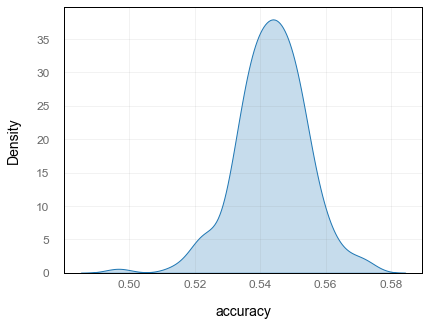

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"  # Replace with a font available on your system


# Load the scan results from the saved CSV file
scan_results = pd.read_csv('scan_results.csv')

# Plot a KDE plot for the 'accuracy' metric
sns.kdeplot(data=scan_results, x='accuracy', fill=True)

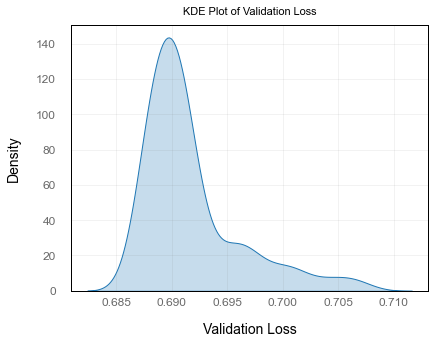

In [28]:


# Plot a KDE plot for the 'val_loss' metric
sns.kdeplot(data=scan_results, x='val_loss', fill=True)

# Add labels and title
plt.xlabel('Validation Loss')
plt.ylabel('Density')
plt.title('KDE Plot of Validation Loss')

# Show the plot
plt.show()


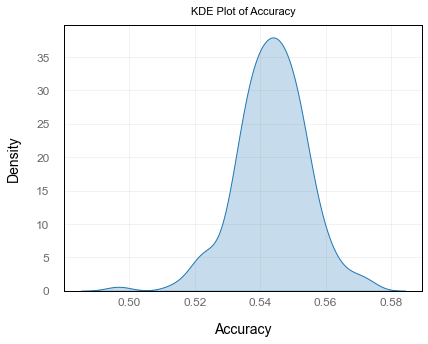

In [29]:
# Plot a KDE plot for the 'accuracy' metric
sns.kdeplot(data=scan_results, x='accuracy', fill=True)

# Add labels and title
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('KDE Plot of Accuracy')

# Show the plot
plt.show()

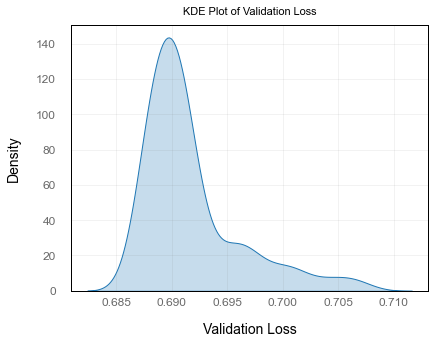

In [32]:
# Set a default font for matplotlib and seaborn
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"

# Plot a KDE plot for the 'val_loss' metric
sns.kdeplot(data=scan_results, x='val_loss', fill=True)

# Add labels and title
plt.xlabel('Validation Loss')
plt.ylabel('Density')
plt.title('KDE Plot of Validation Loss')

# Show the plot
plt.show()

Mean precision: 0.551946371273939


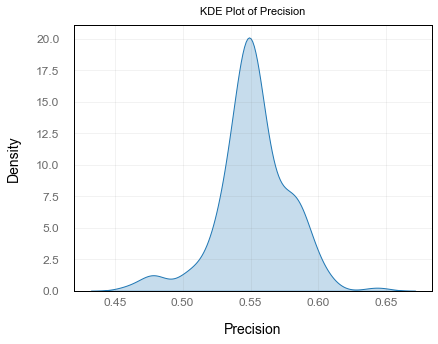

In [37]:

# Print the 'precision' metric
print("Mean precision:", scan_results['precision'].mean())

# Plot a KDE plot for the 'precision' metric
sns.kdeplot(data=scan_results, x='precision', fill=True)

# Add labels and title
plt.xlabel('Precision')
plt.ylabel('Density')
plt.title('KDE Plot of Precision')

# Show the plot
plt.show()

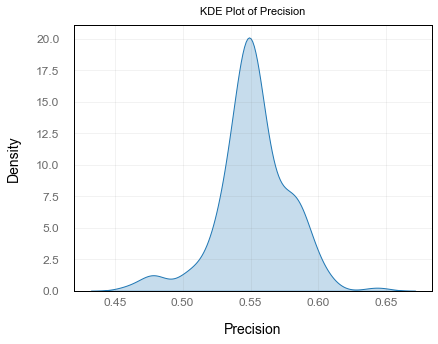

In [38]:
# Plot a KDE plot for the 'precision' metric
sns.kdeplot(data=scan_results, x='precision', fill=True)

# Add labels and title
plt.xlabel('Precision')
plt.ylabel('Density')
plt.title('KDE Plot of Precision')

# Show the plot
plt.show()

Mean recall: 0.7336277918413628


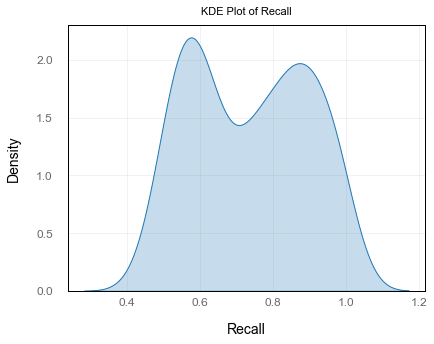

In [39]:
# Print the 'recall' metric
print("Mean recall:", scan_results['recall'].mean())

# Plot a KDE plot for the 'recall' metric
sns.kdeplot(data=scan_results, x='recall', fill=True)

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Density')
plt.title('KDE Plot of Recall')

# Show the plot
plt.show()

Mean f1: 0.6080734762688016


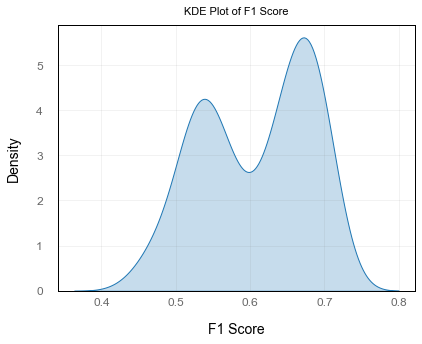

In [40]:
# Print the 'f1' metric
print("Mean f1:", scan_results['f1'].mean())

# Plot a KDE plot for the 'f1' metric
sns.kdeplot(data=scan_results, x='f1', fill=True)

# Add labels and title
plt.xlabel('F1 Score')
plt.ylabel('Density')
plt.title('KDE Plot of F1 Score')

# Show the plot
plt.show()

findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not found.
findfont: Font family 'Geneva' not

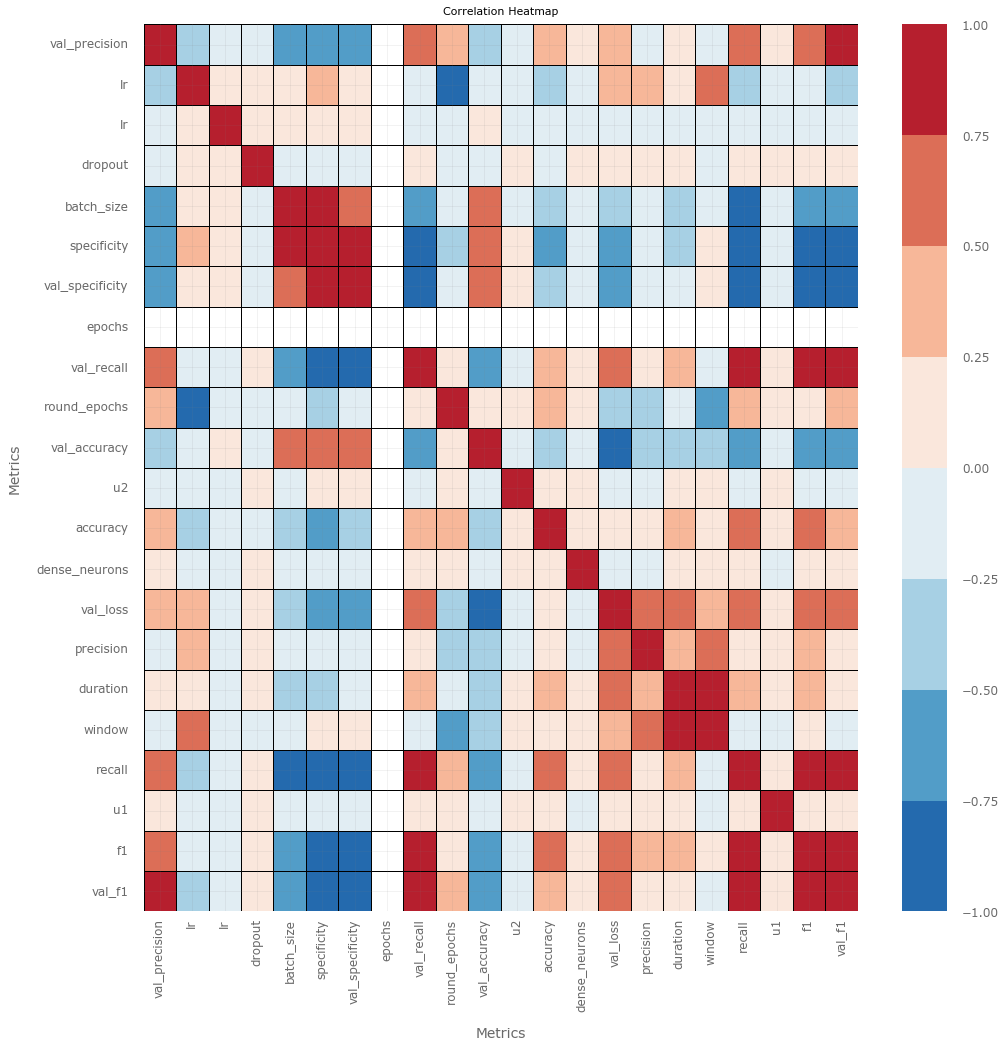

In [86]:
# Access and plot correlation
corr_data = talos.Analyze(scan)


# Plot correlation heatmap
with suppress_stderr():
    corr_data.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

# Set title and labels
plt.title("Correlation Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Metrics")

# Show the plot
plt.show()

None of the hyperparameters seem to correlated significantly with the metrics.
Deploying the best model:

In [92]:
talos.Deploy(scan_object=scan, model_name='classifier1', metric='val_loss')

Deploy package classifier1 have been saved.


In [93]:
classifier = talos.Restore('classifier1.zip')

Best configuration:

In [94]:
best = scan.data.sort_values('val_loss').iloc[0][4:]
best

loss               0.689311
accuracy           0.539799
precision          0.525314
recall             0.608025
f1                 0.543835
specificity        0.387961
val_loss           0.687035
val_accuracy       0.551929
val_precision      0.431042
val_recall         0.528956
val_f1             0.454057
val_specificity    0.451045
lr                      0.0
lr                     0.01
u1                      256
u2                      256
dropout                 0.5
batch_size               64
epochs                  100
optimizer              Adam
activation              elu
dense_neurons            32
window                   50
Name: 105, dtype: object

### Running with best configuration

In [95]:
# best = best.to_dict()
optimal_params = {'lr': best['lr'],
        'u1': best['u1'],
        'u2': best['u2'],
        'dropout': best['dropout'],
        'batch_size': best['batch_size'],
        'epochs': best['epochs'],
        'optimizer': best['optimizer'],
        'activation': best['activation'],
        'dense_neurons': best['dense_neurons'],
        'window': best['window'],
        }

optimal_params

{'lr': lr     0.0
 lr    0.01
 Name: 105, dtype: object,
 'u1': 256,
 'u2': 256,
 'dropout': 0.5,
 'batch_size': 64,
 'epochs': 100,
 'optimizer': 'Adam',
 'activation': 'elu',
 'dense_neurons': 32,
 'window': 50}

In [96]:
optimal_params

{'lr': lr     0.0
 lr    0.01
 Name: 105, dtype: object,
 'u1': 256,
 'u2': 256,
 'dropout': 0.5,
 'batch_size': 64,
 'epochs': 100,
 'optimizer': 'Adam',
 'activation': 'elu',
 'dense_neurons': 32,
 'window': 50}

In [97]:
tf.keras.backend.clear_session()
#This function defines the LSTM model
win_length = optimal_params['window']
batch_size = optimal_params['batch_size']
num_features= x_train.shape[1]
train_generator = TimeseriesGenerator(scaledtrain, y_train, length= win_length, sampling_rate = 1, batch_size= batch_size)
test_generator = TimeseriesGenerator(scaledtest, y_test, length= win_length, sampling_rate = 1, batch_size= batch_size)
#==================================================================#
# MODEL ARCHITECTURE
model = Sequential()
#Input and first LSTM layer:
model.add(LSTM(units=optimal_params['u1'], input_shape = (win_length, num_features), \
return_sequences=True))
# Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add second layer LSTM
model.add(LSTM(units=optimal_params['u2'], return_sequences=False))
#Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add a Dense layer
model.add(Dense(optimal_params['dense_neurons'], activation = optimal_params['activation']))

#Add the output layer – output layer
model.add(Dense(1, activation = 'sigmoid'))#output layer

#==================================================================#
# Defining Early Stopping to avoid overfitting (after 3 attempts)
early_stopping = EarlyStopping(monitor='val_loss',patience = 30, mode='min', restore_best_weights=True)

# Using exponential decay:

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compiling
# (lr=lr_normalizer(optimal_params['lr'], optimal_params['optimizer']))
# callbacks = [early_stopping, callbacklr],
model.compile(loss='binary_crossentropy', 
                optimizer = optimal_params['optimizer'], 
                metrics=['accuracy',precision,recall,f1,specificity,])

history = model.fit(train_generator,
                    validation_data=test_generator, # validation sample with features
                    epochs = 200, # validation sample with labels
                    shuffle=False, callbacks = [early_stopping, callbacklr],#callbacklr
                    class_weight = class_weight, # imbalanced data
                    verbose=1
                    )

Epoch 1/200
24/24 [==============================] - 20s 625ms/step - loss: 0.6991 - accuracy: 0.5171 - precision: 0.4929 - recall: 0.6006 - f1: 0.5126 - specificity: 0.3863 - val_loss: 0.7228 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 2/200
24/24 [==============================] - 15s 620ms/step - loss: 0.6937 - accuracy: 0.5344 - precision: 0.4305 - recall: 0.5390 - f1: 0.4269 - specificity: 0.4523 - val_loss: 0.7197 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 3/200
24/24 [==============================] - 13s 533ms/step - loss: 0.6913 - accuracy: 0.5405 - precision: 0.3994 - recall: 0.6022 - f1: 0.4644 - specificity: 0.3979 - val_loss: 0.7025 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000 - lr: 0.0010
Epoch 4/200
2

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



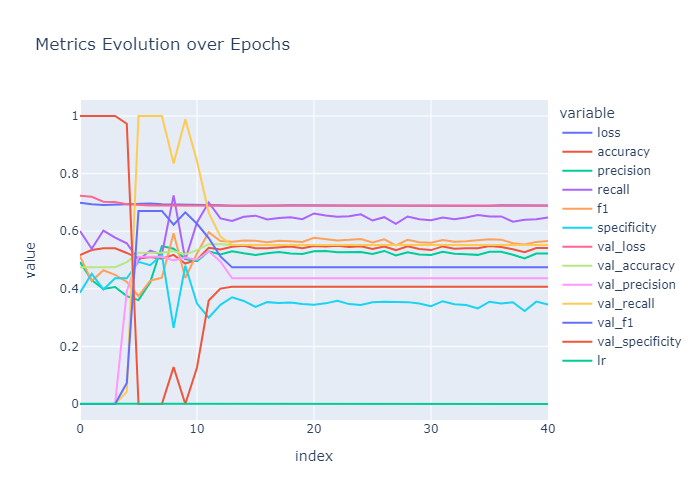

In [98]:
fig = px.line(history.history, title='Metrics Evolution over Epochs')
fig.show('png')

In [99]:
hist_metrics = pd.DataFrame(history.history)
hist_metrics


,loss,accuracy,precision,recall,f1,specificity,val_loss,val_accuracy,val_precision,val_recall,val_f1,val_specificity,lr
0,0.699109,0.517057,0.492895,0.600581,0.512626,0.386289,0.722771,0.474777,0.000000,0.000000,0.000000,1.000000,1.000000e-03
1,0.693673,0.534448,0.430537,0.538984,0.426891,0.452336,0.719675,0.474777,0.000000,0.000000,0.000000,1.000000,1.000000e-03
2,0.691316,0.540468,0.399375,0.602208,0.464383,0.397868,0.702472,0.474777,0.000000,0.000000,0.000000,1.000000,1.000000e-03
3,0.692146,0.540468,0.406423,0.577510,0.448252,0.436741,0.701258,0.474777,0.000000,0.000000,0.000000,1.000000,1.000000e-03
4,0.694332,0.524415,0.374594,0.558193,0.424410,0.436761,0.693630,0.492582,0.391667,0.042431,0.073256,0.973291,1.000000e-03
5,0.695549,0.505017,0.360776,0.500225,0.374579,0.493773,0.690537,0.525223,0.511336,1.000000,0.670330,0.000000,1.000000e-03
6,0.695759,0.510368,0.422714,0.532782,0.428039,0.481886,0.689636,0.525223,0.511336,1.000000,0.670330,0.000000,1.000000e-03
7,0.693742,0.504348,0.548393,0.518881,0.438830,0.518147,0.689509,0.525223,0.511336,1.000000,0.670330,0.000000,1.000000e-03
8,0.693016,0.517726,0.539050,0.724461,0.592813,0.264252,0.688916,0.531157,0.498820,0.835386,0.622362,0.128154,1.000000e-03
9,0.694049,0.487625,0.503060,0.501332,0.437680,0.479848,0.689262,0.519288,0.508480,0.988889,0.665396,0.000000,1.000000e-03


In [100]:
hist_metrics.columns


Index(['loss', 'accuracy', 'precision', 'recall', 'f1', 'specificity',
       'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1',
       'val_specificity', 'lr'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



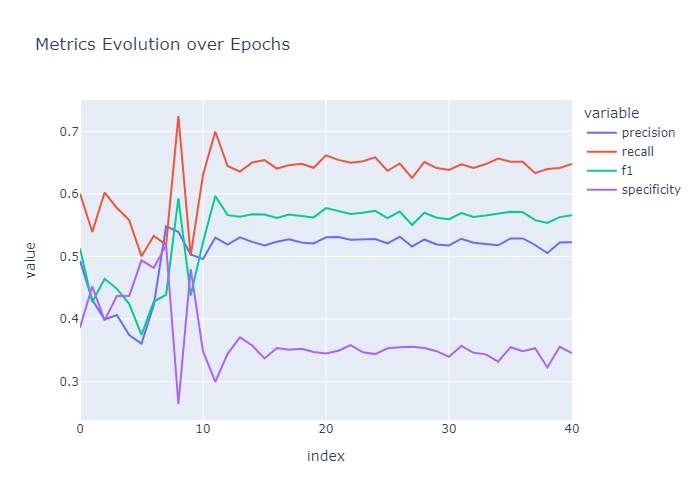

In [101]:
fig = px.line(hist_metrics[['precision','recall','f1','specificity']], title='Metrics Evolution over Epochs')
fig.show('png')

In [102]:
# Predicting
predictions = model.predict(test_generator)
predictions.shape
df_pred = pd.DataFrame(predictions)
df_pred

6/6 [==============================] - 2s 149ms/step


,0
0,0.504525
1,0.502502
2,0.500520
3,0.498541
4,0.497220
...,...
332,0.516456
333,0.517938
334,0.519053
335,0.520394


C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



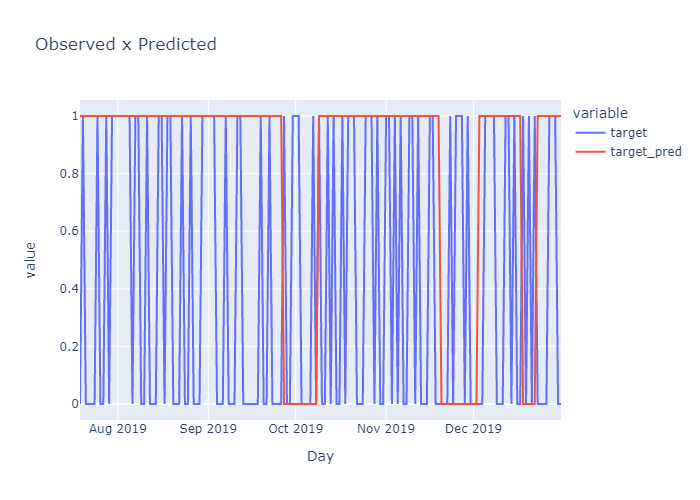

In [107]:
final = df[['target']].iloc[-166:]
df_pred_last_166 = df_pred.values[-166:]  # Slice the values to match the length

final['target_pred'] = np.where(df_pred_last_166 > 0.5, 1, 0)  # Change 0 to 1 for True condition
fig = px.line(final, title='Observed x Predicted')
fig.show('png')

The model does not convert and therefore the classification fails.

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



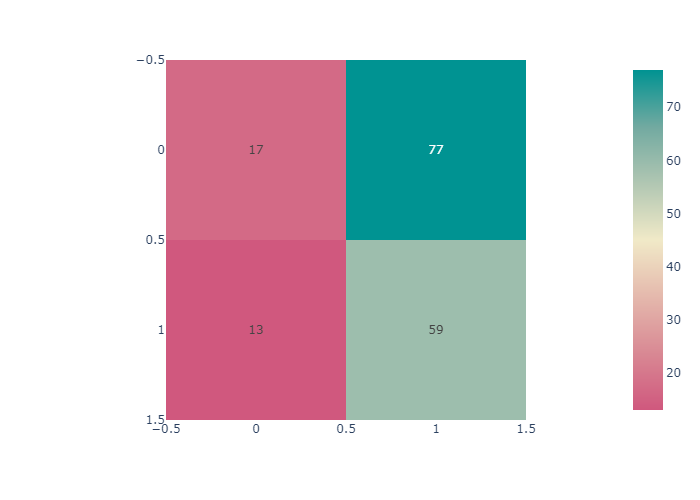

In [108]:
from sklearn.metrics import confusion_matrix

fig = px.imshow(confusion_matrix(final['target'], final['target_pred']), color_continuous_scale='tealrose_r', text_auto=True)
fig.show('png')

In [109]:
# Attempting again with less patience to avoid overfitting
tf.keras.backend.clear_session()
#This function defines the LSTM model
win_length = optimal_params['window']
batch_size = optimal_params['batch_size']
num_features= x_train.shape[1]
train_generator = TimeseriesGenerator(scaledtrain, y_train, length= win_length, sampling_rate = 1, batch_size= batch_size)
test_generator = TimeseriesGenerator(scaledtest, y_test, length= win_length, sampling_rate = 1, batch_size= batch_size)
#==================================================================#
# MODEL ARCHITECTURE
model = Sequential()
#Input and first LSTM layer:
model.add(LSTM(units=optimal_params['u1'], input_shape = (win_length, num_features), \
return_sequences=True))
# Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add second layer LSTM
model.add(LSTM(units=optimal_params['u2'], return_sequences=False))
#Dropout layer
model.add(Dropout(optimal_params['dropout']))
#Add a Dense layer
model.add(Dense(optimal_params['dense_neurons'], activation = optimal_params['activation']))

#Add the output layer – output layer
model.add(Dense(1, activation = 'sigmoid'))#output layer

#==================================================================#
# Defining Early Stopping to avoid overfitting (after 3 attempts)
early_stopping = EarlyStopping(monitor='loss',patience = 5, mode='min', restore_best_weights=True)

# Using exponential decay:

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compiling
# (lr=lr_normalizer(optimal_params['lr'], optimal_params['optimizer']))
# callbacks = [early_stopping, callbacklr],
model.compile(loss='binary_crossentropy', 
                optimizer = optimal_params['optimizer'], 
                metrics=['accuracy',precision,recall,f1,specificity,])

history = model.fit(train_generator,
                    validation_data=test_generator, # validation sample with features
                    epochs = 200, # validation sample with labels
                    shuffle=False, callbacks = [early_stopping, ],#callbacklr
                    class_weight = class_weight, # imbalanced data
                    verbose=1
                    )

Epoch 1/200
24/24 [==============================] - 19s 570ms/step - loss: 0.6953 - accuracy: 0.5452 - precision: 0.5188 - recall: 0.5970 - f1: 0.5121 - specificity: 0.4294 - val_loss: 0.7385 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/200
24/24 [==============================] - 12s 508ms/step - loss: 0.6915 - accuracy: 0.5458 - precision: 0.4631 - recall: 0.5852 - f1: 0.4790 - specificity: 0.4210 - val_loss: 0.7158 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/200
24/24 [==============================] - 11s 474ms/step - loss: 0.6929 - accuracy: 0.5331 - precision: 0.3988 - recall: 0.5359 - f1: 0.4235 - specificity: 0.4587 - val_loss: 0.7098 - val_accuracy: 0.4748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/200
24/24 [==============================] -

6/6 [==============================] - 1s 173ms/step


C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



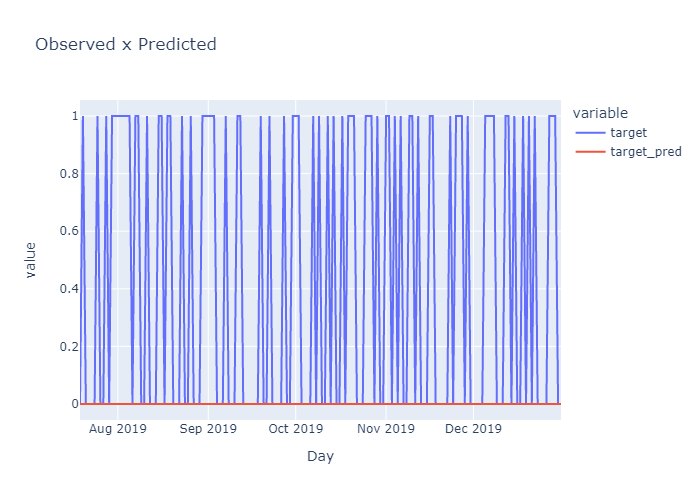

In [111]:
# Predicting
predictions = model.predict(test_generator)
predictions.shape
df_pred = pd.DataFrame(predictions)

# As the output is a probability
final = df[['target']].iloc[-166:]
final['target_pred'] = np.where(df_pred.iloc[-166:].values > 0.5, 1, 0)  # Change 0 to 1 for True condition
fig = px.line(final, title='Observed x Predicted')
fig.show('png')
